In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime, timedelta
from scipy.optimize import curve_fit

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

## Global COVID-19 Analysis

In [3]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]
cases



Total number of cases (in countries with at least 100 cases) as of 4/2/20


4/2/20
Country/Region        
US              243453
Italy           115242
Spain           112065
Germany          84794
China            82432
...                ...
Kosovo             125
Bolivia            123
Kyrgyzstan         116
Cambodia           110
Kenya              110

[112 rows x 1 columns]

## US State Measures

In [4]:
import requests

location_state_list = []
location_hashmap = dict()

def process_locations():
    r = requests.get("https://covid19.healthdata.org/api/metadata/location")
    j = r.json()
    
    for loc in j:
        if loc.get("location_name") == "United States of America":
            continue
        
        location_hashmap[loc.get("location_name")] = loc["location_id"]
        location_state_list.append(loc.get("location_name"))

process_locations()

measures_taken_per_state = dict()

def fetch_state_info(state):
    location_id = location_hashmap.get(state)
    
    intervention_url = 'https://covid19.healthdata.org/api/data/intervention?location='+str(location_id)

    r = requests.get(intervention_url)
    j = r.json()
    
    measures_taken_per_state[state] = []

    for intervention in j:
        date_format = "%Y-%m-%d %H:%M:%S"
        
        measures_taken_per_state[state].append(dict(
            measure=intervention["covid_intervention_measure_name"],
            reported=datetime.strptime(intervention["date_reported"], date_format)
        ))
    
    return measures_taken_per_state[state]

def populate_locations():
    for state in location_state_list:
        print("Processing state measures", state)
        fetch_state_info(state)
    
    no_measure_states = []
    one_measure_states = []
    two_measure_states = []
    
    for state in location_state_list:
        if len(measures_taken_per_state.get(state)) == 0:
            no_measure_states.append(state)
        if len(measures_taken_per_state.get(state)) == 1:
            one_measure_states.append(state)
        if len(measures_taken_per_state.get(state)) == 2:
            two_measure_states.append(state)
    
    states_without_stay_at_home = []
    
    for state in location_state_list:
        no_stay_at_home = True
        for measure in measures_taken_per_state.get(state):
            if measure["measure"] == "People instructed to stay at home":
                no_stay_at_home = False
        
        if no_stay_at_home:
            states_without_stay_at_home.append(state)
            
    states_without_closures = []
    
    for state in location_state_list:
        no_closures = True
        for measure in measures_taken_per_state.get(state):
            if measure["measure"] == "Non-essential services closed (i.e., bars/restaurants)":
                no_closures = False
        
        if no_closures:
            states_without_closures.append(state)
            
        
            
    print("0 measure States:")
    print(", ".join(no_measure_states))
    print("1 measure States:")
    print(", ".join(one_measure_states))
    print("2 measure States:")
    print(", ".join(two_measure_states))
    
    print("States without stay at home orders:")
    print(", ".join(states_without_stay_at_home))
    
    print("States without closures of non-essential services:")
    print(", ".join(states_without_closures))

populate_locations()

def get_state_measures(state):
    return measures_taken_per_state.get(state, None)


Processing state measures Alabama
Processing state measures Alaska
Processing state measures Arizona
Processing state measures Arkansas
Processing state measures California
Processing state measures Colorado
Processing state measures Connecticut
Processing state measures Delaware
Processing state measures District of Columbia
Processing state measures Florida
Processing state measures Georgia
Processing state measures Hawaii
Processing state measures Idaho
Processing state measures Illinois
Processing state measures Indiana
Processing state measures Iowa
Processing state measures Kansas
Processing state measures Kentucky
Processing state measures Louisiana
Processing state measures Maine
Processing state measures Maryland
Processing state measures Massachusetts
Processing state measures Michigan
Processing state measures Minnesota
Processing state measures Mississippi
Processing state measures Missouri
Processing state measures Montana
Processing state measures Nebraska
Processing stat

## Curve Fitting Global COVID-19 Cases

In [5]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    x_pred = np.arange(y.size+21) # 3 weeks into the future
    
    # Only predict based on figures above 10
    skip_days = 0
    
    for day in range(len(y)):
        cases = y[day]
        
        if cases > 10:
            skip_days = day
            break
    
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    plt.figure(figsize=(20,10))
    plt.plot(x, y, 'ko', label="Original Data")
    
    logisticworked = False
    exponentialworked = False
    
    # Draw our skip days line
    plt.axvline(x=skip_days,label="Fit after this")
    
    # Draw our date lines
    plt.axvline(x=y.size,label=mostrecentdate,color="pink")
    most_recent_date_as_index = y.size-1
    date_format = "%m/%d/%y"
    aus_date_format = "%d/%m/%y"
    most_recent_date_as_date = datetime.strptime(mostrecentdate, date_format)
    
    in_7_days_date = most_recent_date_as_date+timedelta(days=7)
    in_14_days_date = most_recent_date_as_date+timedelta(days=14)

    plt.axvline(x=most_recent_date_as_index+7,label=in_7_days_date.strftime(aus_date_format),color="orange")
    plt.axvline(x=most_recent_date_as_index+14,label=in_14_days_date.strftime(aus_date_format),color="purple")
    
    # Check if this state has had measures taken
    state_measures = get_state_measures(country)
    
    if not state_measures == None:
        for measure in state_measures:
            days_before_latest = (most_recent_date_as_date - measure["reported"]).days
            index_of_measure = most_recent_date_as_index - days_before_latest
            
            plt.axvline(x=index_of_measure,label=measure["measure"] + " on " +  measure["reported"].strftime(aus_date_format),color="green")
        
    try:
        lpopt, lpcov = curve_fit(logistic, x[skip_days:], y[skip_days:], maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.95:
            plt.plot(x_pred, logistic(x_pred, lpopt[0], lpopt[1]-lerror[1], lpopt[2], lpopt[3]), 'b--', label="LgstcCrv Fit Low")
            plt.plot(x_pred, logistic(x_pred, lpopt[0], lpopt[1]+lerror[1], lpopt[2], lpopt[3]), 'b--', label="LgstcCrv Fit High")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tSkipping', skip_days, "days")
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x[skip_days:], y[skip_days:], bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        # calculate R^2
        
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x_pred, exponential(x_pred, epopt[0], epopt[1]-eerror[1], epopt[2]), 'r--', label="ExpCrv Fit Low")
            plt.plot(x_pred, exponential(x_pred, epopt[0], epopt[1]+eerror[1], epopt[2]), 'r--', label="ExpCrv Fit High")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tSkipping', skip_days, "days")
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            
            exponentialworked = True
            
    except:
        pass
    
    plt.title(country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.yscale('log')
    plt.ylim(bottom=1)
    
    

    
    plt.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]



US

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 243453
	Confirmed cases on 3/26/20 	 83836
	Ratio: 2.9
	Weekly increase: 190.4 %
	Daily increase: 16.5 % per day
	Doubling Time (represents recent growth): 4.6 days

** Based on Exponential Fit **

	R^2: 0.9921039300534396
	Skipping 12 days
	Doubling Time (represents overall growth):  4.02 (± 0.2 ) days


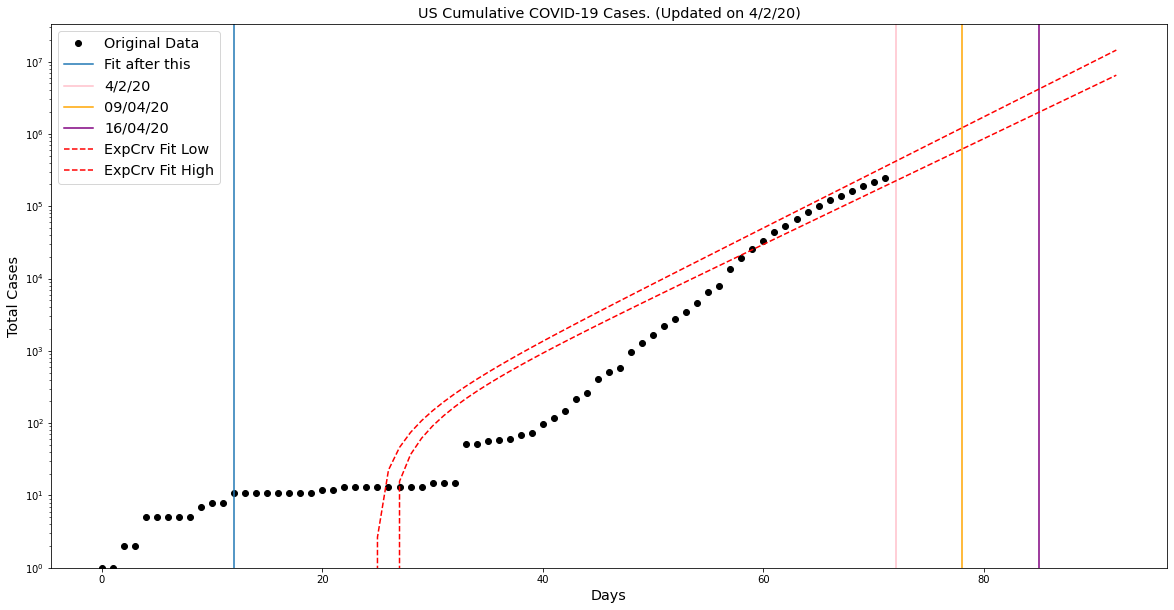



Italy

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 115242
	Confirmed cases on 3/26/20 	 80589
	Ratio: 1.43
	Weekly increase: 43.0 %
	Daily increase: 5.2 % per day
	Doubling Time (represents recent growth): 13.6 days

** Based on Logistic Fit**

	R^2: 0.999523516341662
	Skipping 21 days
	Doubling Time (during middle of growth):  7.99 (± 0.25 ) days


/Users/michaelorenstein/Virtualenvs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


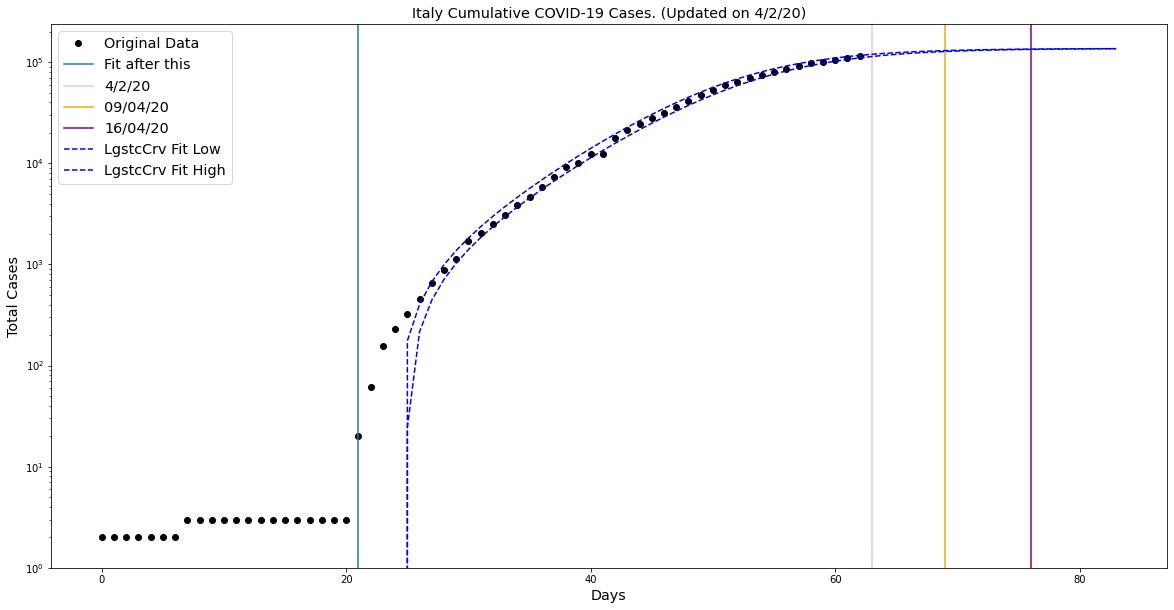



Australia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 5116
	Confirmed cases on 3/26/20 	 2810
	Ratio: 1.82
	Weekly increase: 82.1 %
	Daily increase: 8.9 % per day
	Doubling Time (represents recent growth): 8.1 days

** Based on Exponential Fit **

	R^2: 0.9787978964576062
	Skipping 6 days
	Doubling Time (represents overall growth):  5.68 (± 0.46 ) days


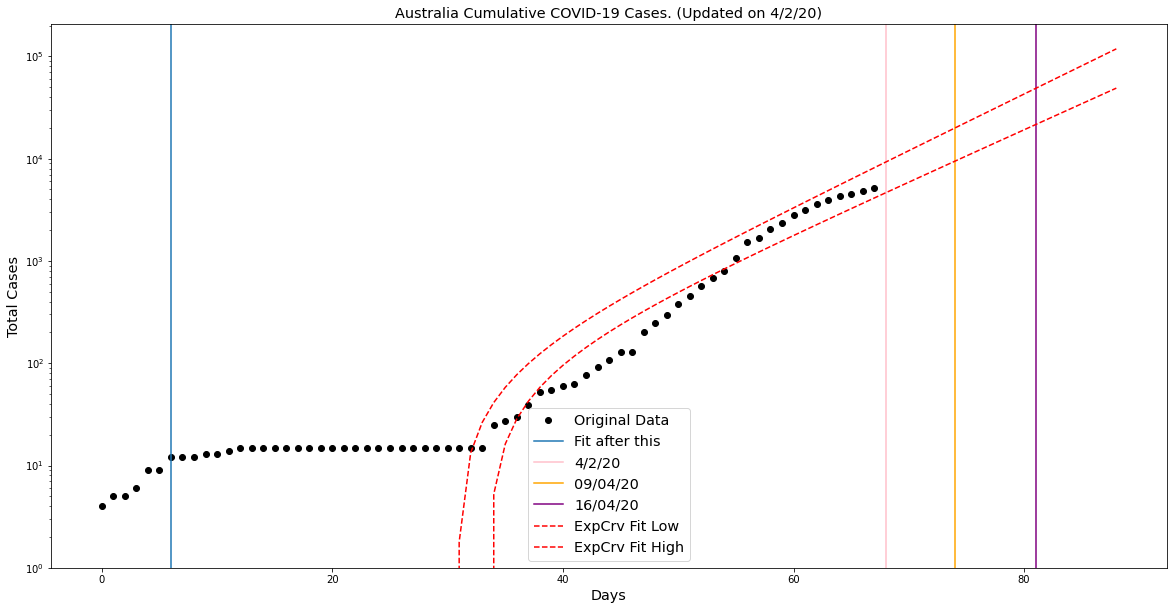

In [6]:
topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
print('\n')

for c in topcountries:
    
    if c != "US" and c != "Australia" and c != "Italy":
        continue
    
    print(c)
        
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for Global COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


   Inferred Doubling Time  95%CI  Recent Doubling Time
0                     4.0    0.2                   4.6
1                     8.0    0.2                  13.6
2                     5.7    0.5                   8.1




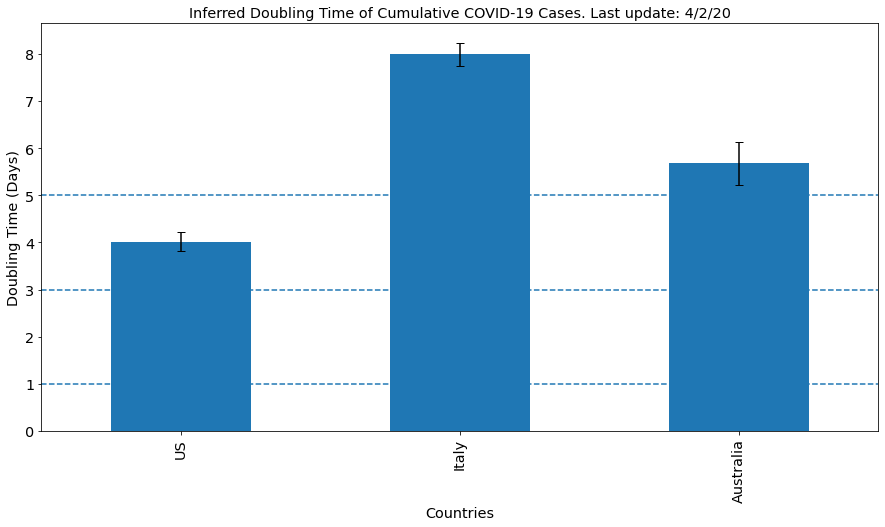

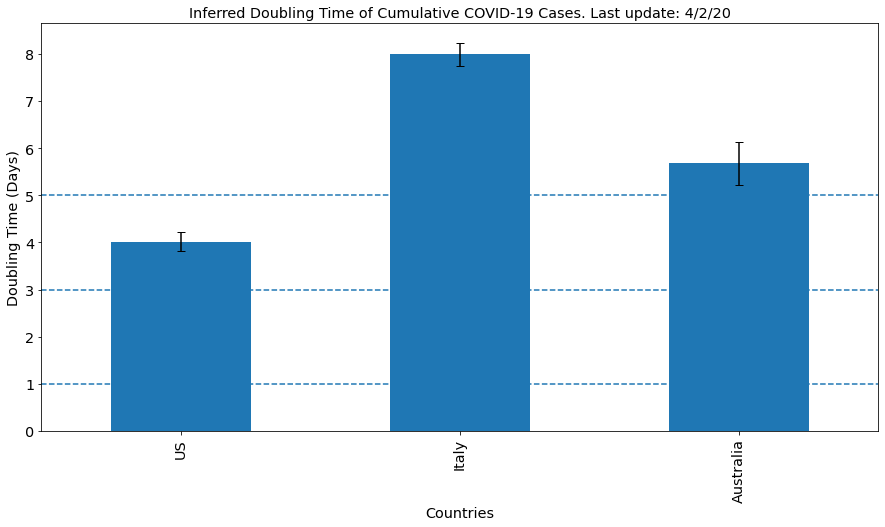

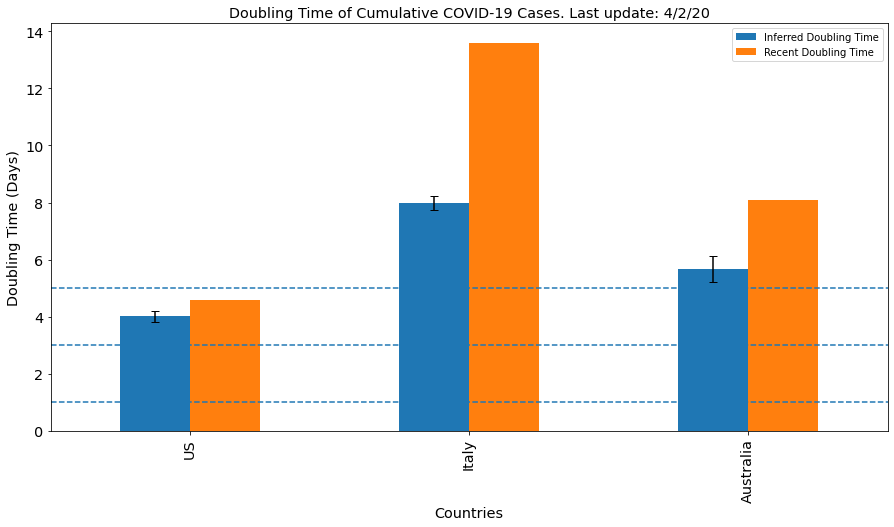

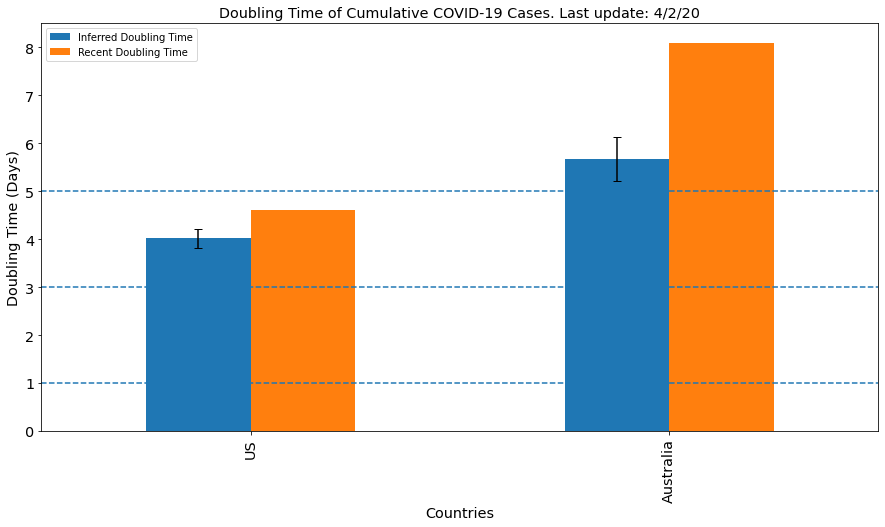

In [7]:
d = {'Countries': countries, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')

print(pd.DataFrame(data=d).iloc[:,[1,2,3]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 10]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=countries
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 10]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

## US COVID-19 Analysis

In [8]:
uscases = pd.read_csv('https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')

# For some reason they change column names, change them back.
uscases.rename(columns={
    'Country_Region':'Country/Region',
    'Province_State':'Province/State',
    'Long_':'Long'
}, inplace=True)


# US states lookup from https://code.activestate.com/recipes/577305-python-dictionary-of-us-states-and-territories/
# with DC added
states = { 'AK': 'Alaska', 'AL': 'Alabama', 'AR': 'Arkansas', 'AS': 'American Samoa', 'AZ': 'Arizona', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DC': 'District of Columbia', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'GU': 'Guam', 'HI': 'Hawaii', 'IA': 'Iowa', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'MA': 'Massachusetts', 'MD': 'Maryland', 'ME': 'Maine', 'MI': 'Michigan', 'MN': 'Minnesota', 'MO': 'Missouri', 'MP': 'Northern Mariana Islands', 'MS': 'Mississippi', 'MT': 'Montana', 'NA': 'National', 'NC': 'North Carolina', 'ND': 'North Dakota', 'NE': 'Nebraska', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NV': 'Nevada', 'NY': 'New York', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'PR': 'Puerto Rico', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VA': 'Virginia', 'VI': 'Virgin Islands', 'VT': 'Vermont', 'WA': 'Washington', 'WI': 'Wisconsin', 'WV': 'West Virginia', 'WY': 'Wyoming', 'D.C.': 'District of Columbia'}

# global
# Province/State,Country/Region,Lat,Long,1/22/20

# US
# UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/2020

# Province/State  Country/Region      Lat     Long  1/22/20
uscases = uscases.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Combined_Key'])

usstatesummary = uscases.iloc[:,[0,-1]].groupby('Province/State').sum()

mostrecentdate = usstatesummary.columns[0]
usstatesummary = usstatesummary.sort_values(by = mostrecentdate, ascending = False)
usstatesummary = usstatesummary[usstatesummary[mostrecentdate] > 0]



print('\nNumber of confirmed US COVID-19 cases by state as of', mostrecentdate)
usstatesummary


Number of confirmed US COVID-19 cases by state as of 4/2/20


4/2/20
Province/State                  
New York                   92506
New Jersey                 25590
Michigan                   10791
California                 10773
Louisiana                   9159
Florida                     9008
Massachusetts               8966
Illinois                    7695
Pennsylvania                7268
Washington                  6389
Georgia                     5348
Texas                       5069
Connecticut                 3824
Colorado                    3342
Indiana                     3038
Ohio                        2901
Tennessee                   2845
Maryland                    2331
North Carolina              1977
Missouri                    1857
Wisconsin                   1748
Arizona                     1715
Virginia                    1706
South Carolina              1554
Nevada                      1463
Alabama                     1233
Mississippi                 1177
Utah                        1092
Oklahoma                     881
Oregon                       826
Idaho                        776
Kentucky                     770
Minnesota                    742
Rhode Island                 657
District of Columbia         653
Arkansas                     643
Iowa                         614
Kansas                       553
Delaware                     393
New Mexico                   388
Maine                        376
Vermont                      338
Puerto Rico                  316
New Hampshire                316
Hawaii                       256
Nebraska                     246
Montana                      241
West Virginia                216
South Dakota                 165
North Dakota                 159
Wyoming                      150
Alaska                       143
Grand Princess               103
Guam                          82
Diamond Princess              49
Virgin Islands                30
Northern Mariana Islands       6

## Curve Fitting US COVID-19 Cases

                      4/2/20
Province/State              
New York               92506
New Jersey             25590
Michigan               10791
California             10773
Louisiana               9159
Florida                 9008
Massachusetts           8966
Illinois                7695
Pennsylvania            7268
Washington              6389
Georgia                 5348
Texas                   5069
Connecticut             3824
Colorado                3342
Indiana                 3038
Ohio                    2901
Tennessee               2845
Maryland                2331
North Carolina          1977
Missouri                1857
Wisconsin               1748
Arizona                 1715
Virginia                1706
South Carolina          1554
Nevada                  1463
Alabama                 1233
Mississippi             1177
Utah                    1092
Oklahoma                 881
Oregon                   826
Idaho                    776
Kentucky                 770
Minnesota     

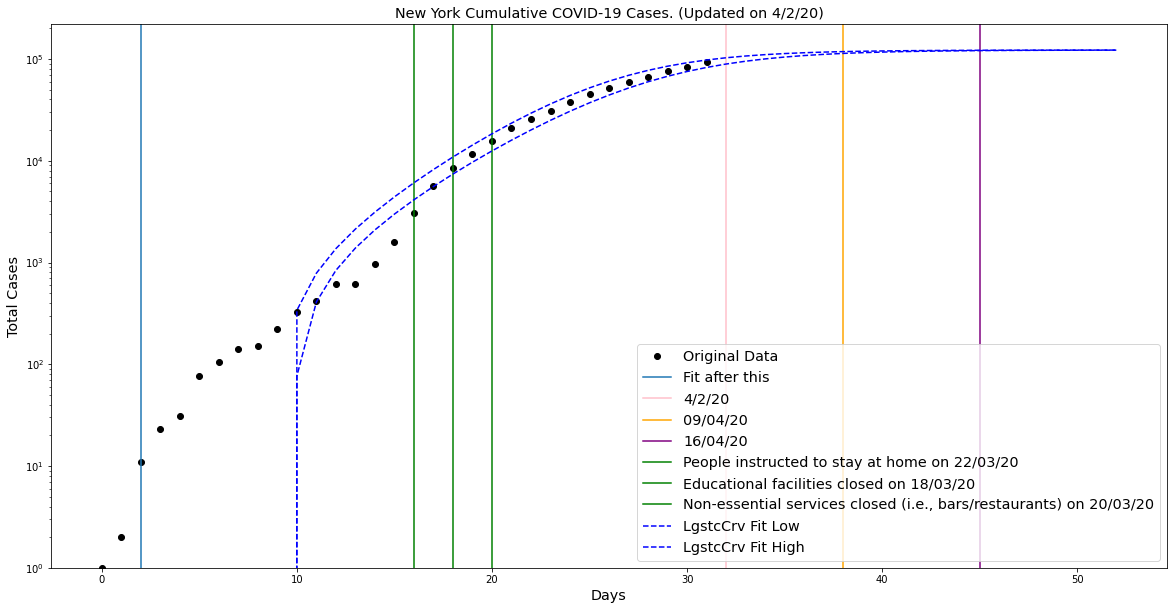



US state:  New Jersey

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 25590
	Confirmed cases on 3/26/20 	 6876
	Ratio: 3.72
	Weekly increase: 272.2 %
	Daily increase: 20.7 % per day
	Doubling Time (represents recent growth): 3.7 days

** Based on Logistic Fit**

	R^2: 0.9990303673127134
	Skipping 5 days
	Doubling Time (during middle of growth):  4.39 (± 0.35 ) days

** Based on Exponential Fit **

	R^2: 0.9886429934814663
	Skipping 5 days
	Doubling Time (represents overall growth):  3.45 (± 0.41 ) days


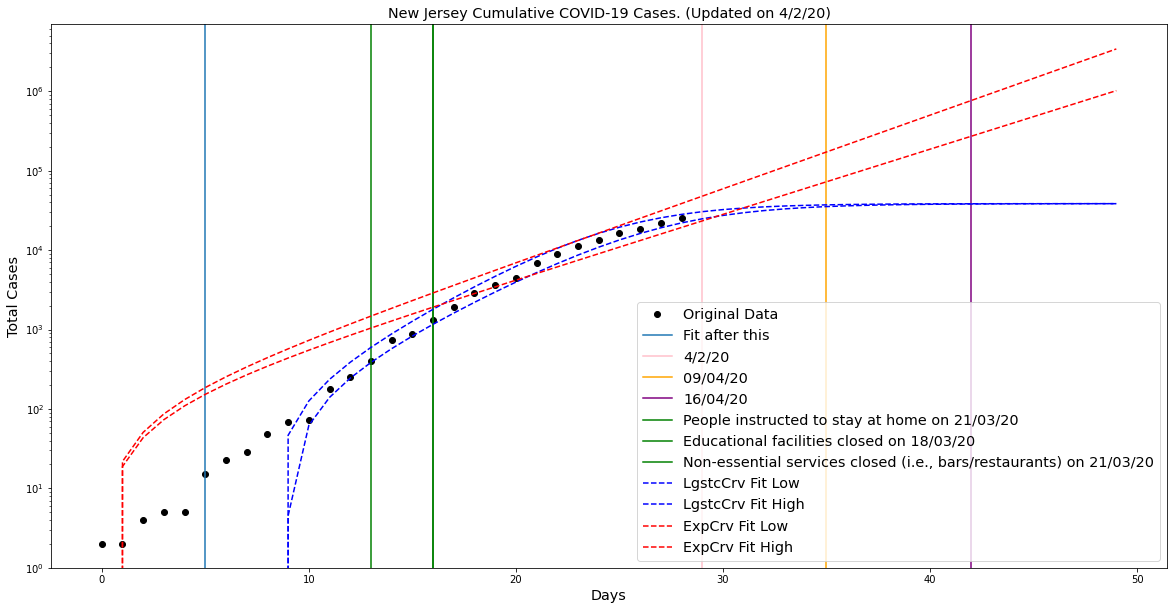



US state:  Michigan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 10791
	Confirmed cases on 3/26/20 	 2845
	Ratio: 3.79
	Weekly increase: 279.3 %
	Daily increase: 21.0 % per day
	Doubling Time (represents recent growth): 3.6 days

** Based on Logistic Fit**

	R^2: 0.9987005445555659
	Skipping 2 days
	Doubling Time (during middle of growth):  5.67 (± 0.68 ) days

** Based on Exponential Fit **

	R^2: 0.9884723888621273
	Skipping 2 days
	Doubling Time (represents overall growth):  3.21 (± 0.41 ) days


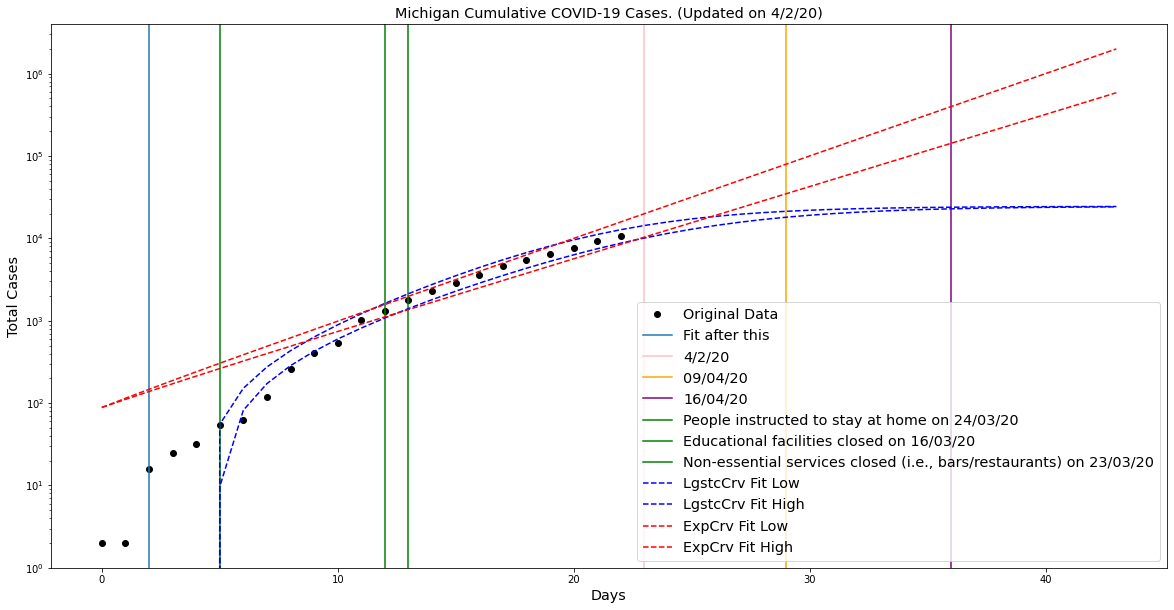



US state:  California

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 10773
	Confirmed cases on 3/26/20 	 3899
	Ratio: 2.76
	Weekly increase: 176.3 %
	Daily increase: 15.6 % per day
	Doubling Time (represents recent growth): 4.8 days

** Based on Exponential Fit **

	R^2: 0.9972478371311978
	Skipping 32 days
	Doubling Time (represents overall growth):  4.39 (± 0.17 ) days


/Users/michaelorenstein/Virtualenvs/jupyter/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


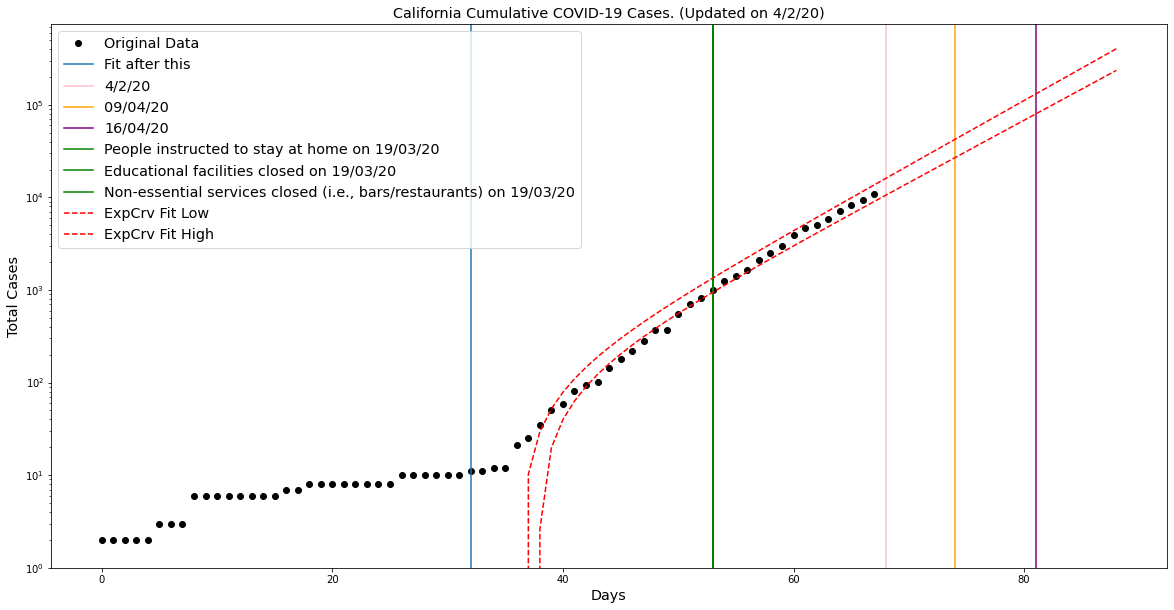



US state:  Louisiana

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 9159
	Confirmed cases on 3/26/20 	 2304
	Ratio: 3.98
	Weekly increase: 297.5 %
	Daily increase: 21.8 % per day
	Doubling Time (represents recent growth): 3.5 days

** Based on Logistic Fit**

	R^2: 0.987975232143595
	Skipping 1 days
	Doubling Time (during middle of growth):  6.72 (± 0.92 ) days

** Based on Exponential Fit **

	R^2: 0.9879752324161798
	Skipping 1 days
	Doubling Time (represents overall growth):  3.36 (± 0.42 ) days


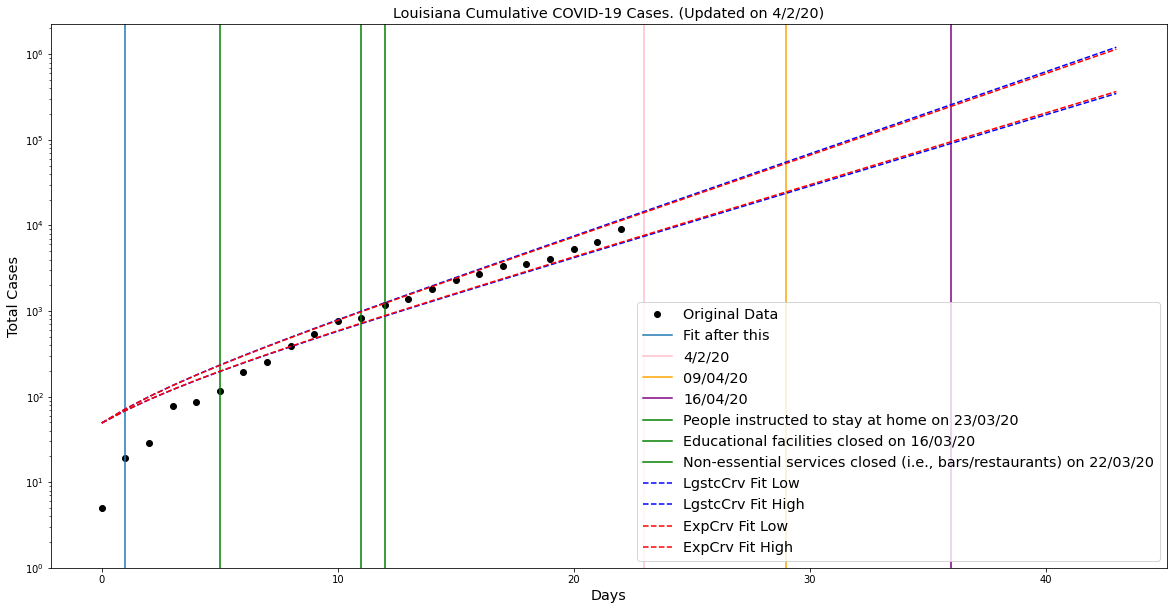



US state:  Florida

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 9008
	Confirmed cases on 3/26/20 	 2357
	Ratio: 3.82
	Weekly increase: 282.2 %
	Daily increase: 21.1 % per day
	Doubling Time (represents recent growth): 3.6 days

** Based on Logistic Fit**

	R^2: 0.9962549726458383
	Skipping 7 days
	Doubling Time (during middle of growth):  5.56 (± 1.03 ) days

** Based on Exponential Fit **

	R^2: 0.993757385640599
	Skipping 7 days
	Doubling Time (represents overall growth):  3.64 (± 0.31 ) days


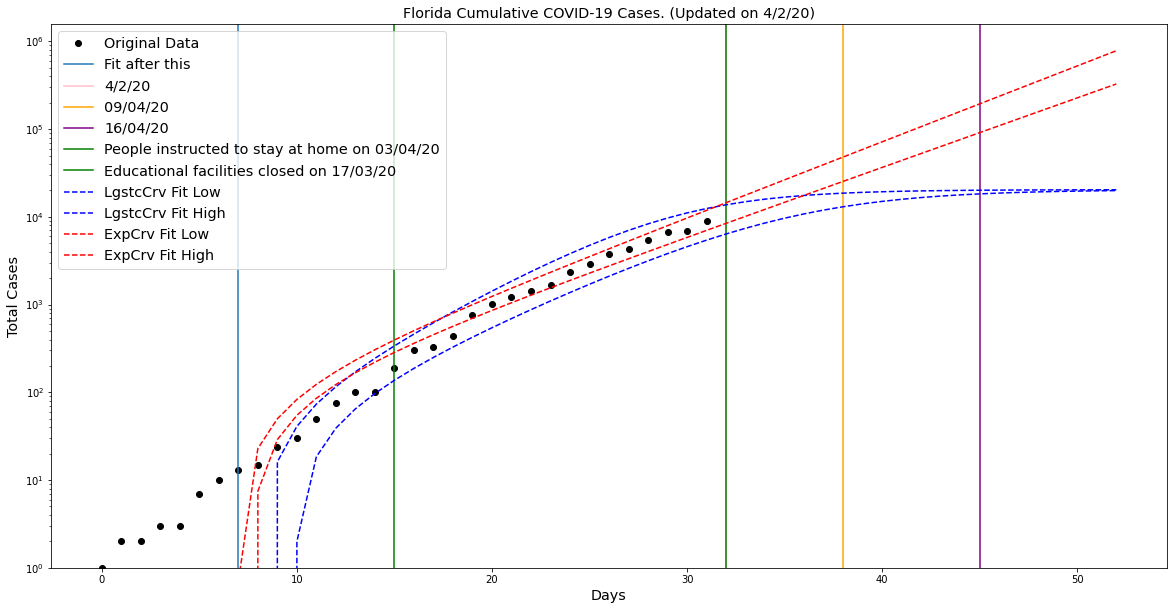



US state:  Massachusetts

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 8966
	Confirmed cases on 3/26/20 	 2417
	Ratio: 3.71
	Weekly increase: 271.0 %
	Daily increase: 20.6 % per day
	Doubling Time (represents recent growth): 3.7 days

** Based on Exponential Fit **

	R^2: 0.9886393772619001
	Skipping 36 days
	Doubling Time (represents overall growth):  3.64 (± 0.42 ) days


/Users/michaelorenstein/Virtualenvs/jupyter/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


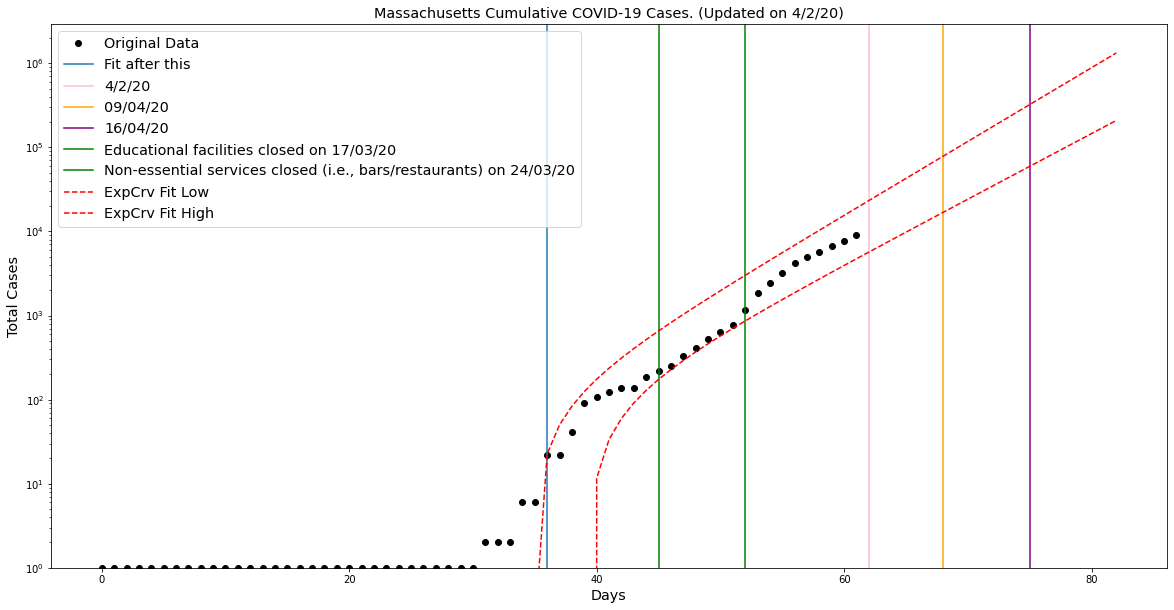



US state:  Illinois

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 7695
	Confirmed cases on 3/26/20 	 2538
	Ratio: 3.03
	Weekly increase: 203.2 %
	Daily increase: 17.2 % per day
	Doubling Time (represents recent growth): 4.4 days

** Based on Exponential Fit **

	R^2: 0.9921581863312392
	Skipping 46 days
	Doubling Time (represents overall growth):  3.99 (± 0.43 ) days


/Users/michaelorenstein/Virtualenvs/jupyter/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


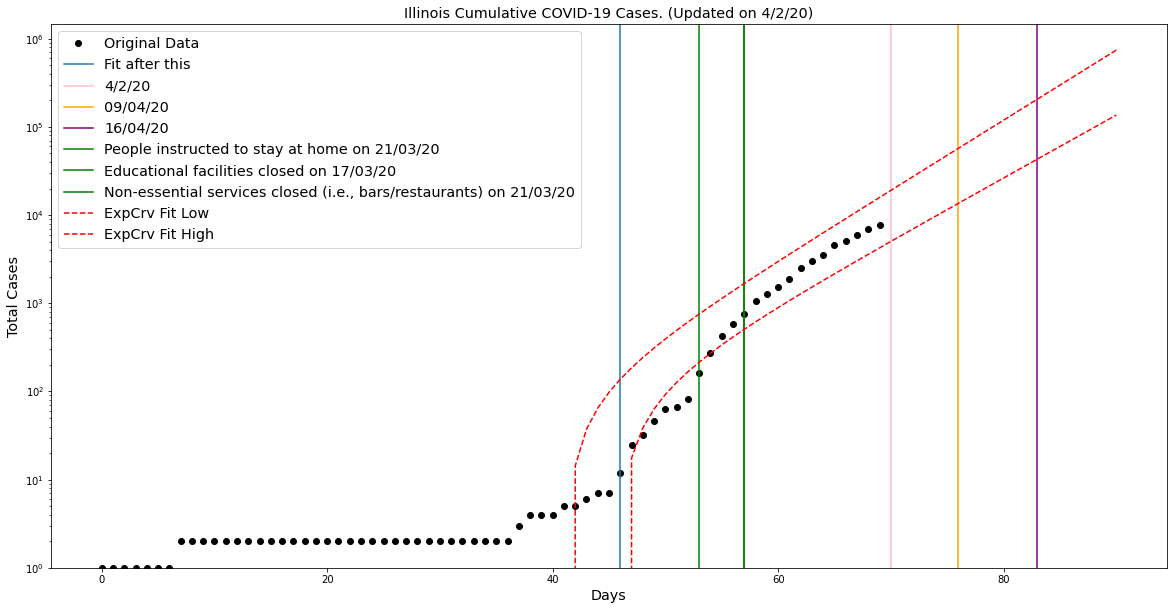



US state:  Pennsylvania

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 7268
	Confirmed cases on 3/26/20 	 1795
	Ratio: 4.05
	Weekly increase: 304.9 %
	Daily increase: 22.1 % per day
	Doubling Time (represents recent growth): 3.5 days

** Based on Logistic Fit**

	R^2: 0.9987964123351906
	Skipping 4 days
	Doubling Time (during middle of growth):  5.21 (± 0.53 ) days

** Based on Exponential Fit **

	R^2: 0.9963524711810857
	Skipping 4 days
	Doubling Time (represents overall growth):  3.41 (± 0.22 ) days


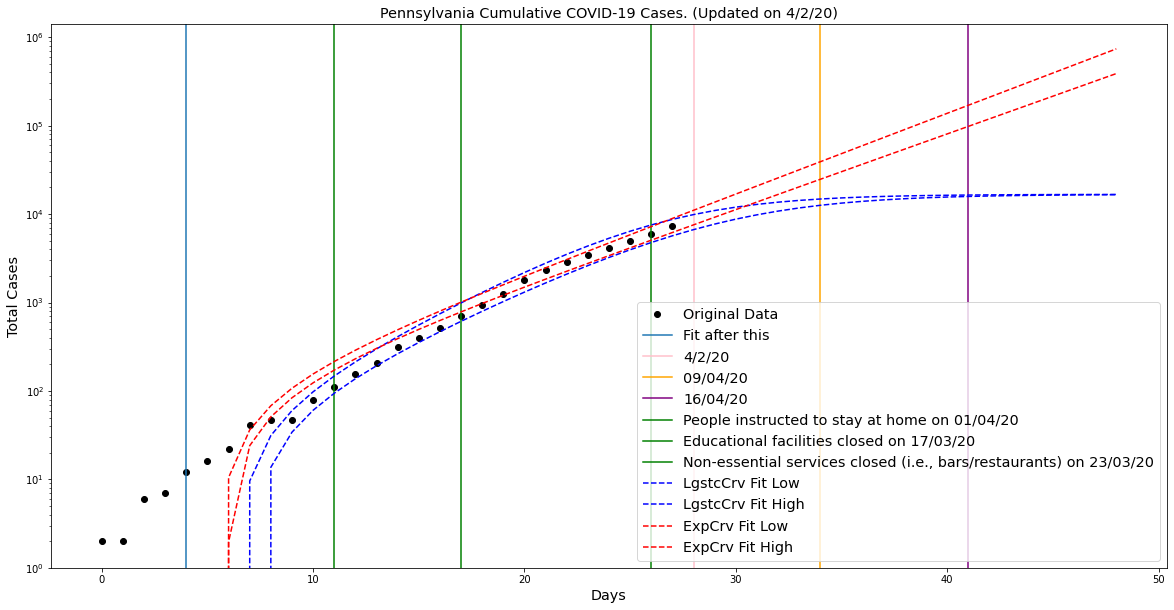



US state:  Washington

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 6389
	Confirmed cases on 3/26/20 	 3207
	Ratio: 1.99
	Weekly increase: 99.2 %
	Daily increase: 10.3 % per day
	Doubling Time (represents recent growth): 7.0 days

** Based on Exponential Fit **

	R^2: 0.9935180484999862
	Skipping 39 days
	Doubling Time (represents overall growth):  6.15 (± 0.54 ) days


/Users/michaelorenstein/Virtualenvs/jupyter/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


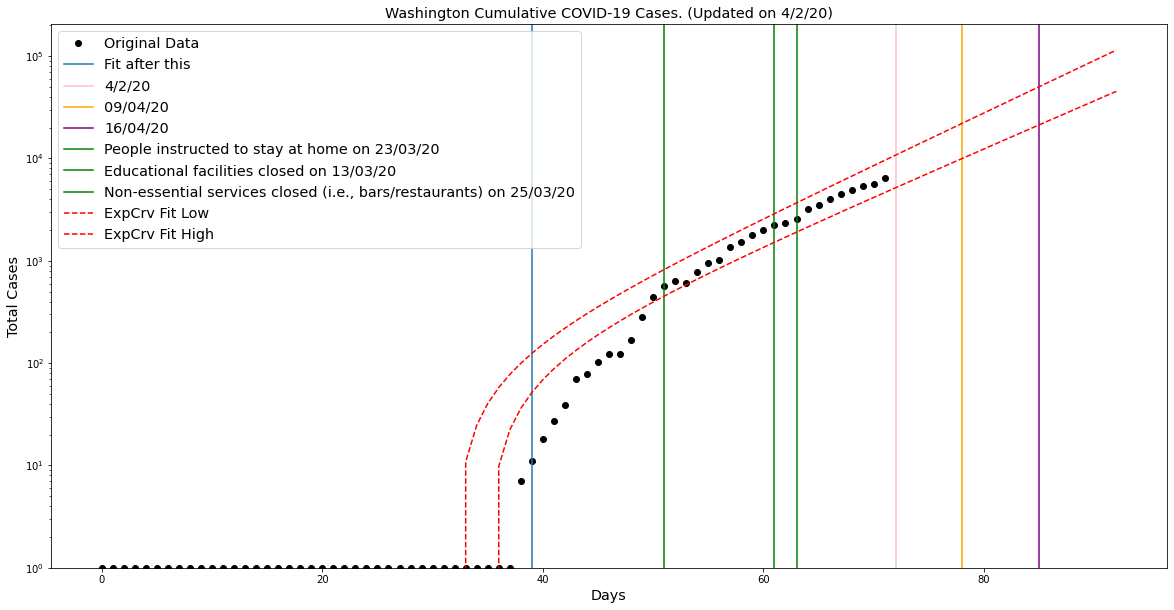



US state:  Georgia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 5348
	Confirmed cases on 3/26/20 	 1525
	Ratio: 3.51
	Weekly increase: 250.7 %
	Daily increase: 19.6 % per day
	Doubling Time (represents recent growth): 3.9 days

** Based on Logistic Fit**

	R^2: 0.9956659543138077
	Skipping 7 days
	Doubling Time (during middle of growth):  7.36 (± 1.94 ) days

** Based on Exponential Fit **

	R^2: 0.9956342097427996
	Skipping 7 days
	Doubling Time (represents overall growth):  3.91 (± 0.3 ) days


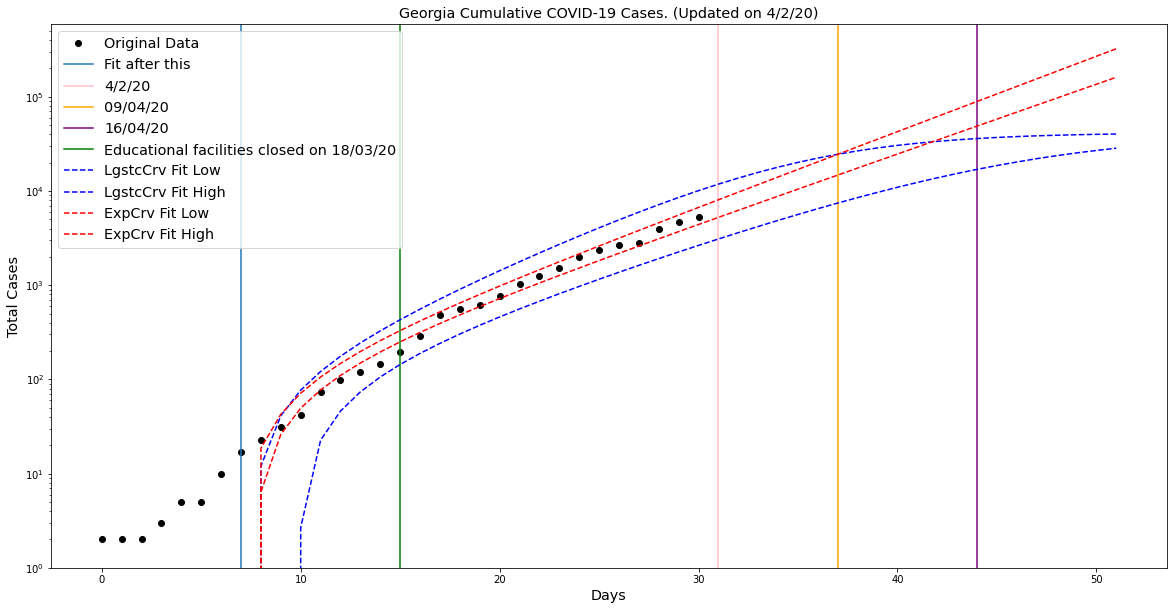



US state:  Texas

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 5069
	Confirmed cases on 3/26/20 	 1563
	Ratio: 3.24
	Weekly increase: 224.3 %
	Daily increase: 18.3 % per day
	Doubling Time (represents recent growth): 4.1 days

** Based on Logistic Fit**

	R^2: 0.9987945902948333
	Skipping 3 days
	Doubling Time (during middle of growth):  5.8 (± 0.56 ) days

** Based on Exponential Fit **

	R^2: 0.9952413630899651
	Skipping 3 days
	Doubling Time (represents overall growth):  4.07 (± 0.3 ) days


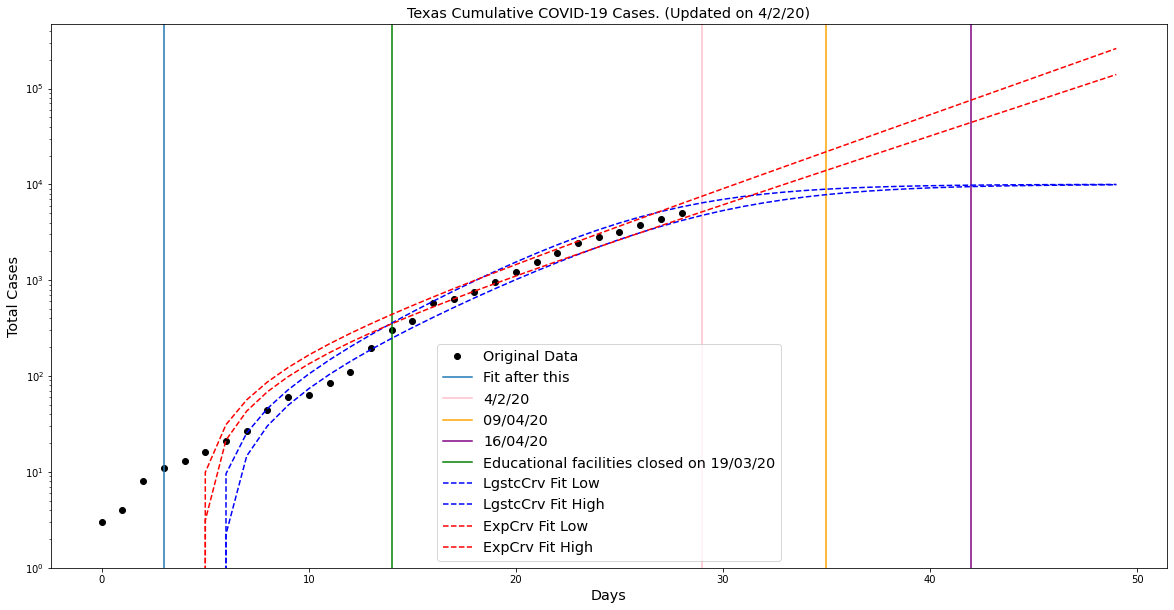



US state:  Connecticut

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 3824
	Confirmed cases on 3/26/20 	 1012
	Ratio: 3.78
	Weekly increase: 277.9 %
	Daily increase: 20.9 % per day
	Doubling Time (represents recent growth): 3.6 days

** Based on Logistic Fit**

	R^2: 0.9977054875341305
	Skipping 3 days
	Doubling Time (during middle of growth):  4.19 (± 0.58 ) days

** Based on Exponential Fit **

	R^2: 0.9892049361371474
	Skipping 3 days
	Doubling Time (represents overall growth):  3.69 (± 0.5 ) days


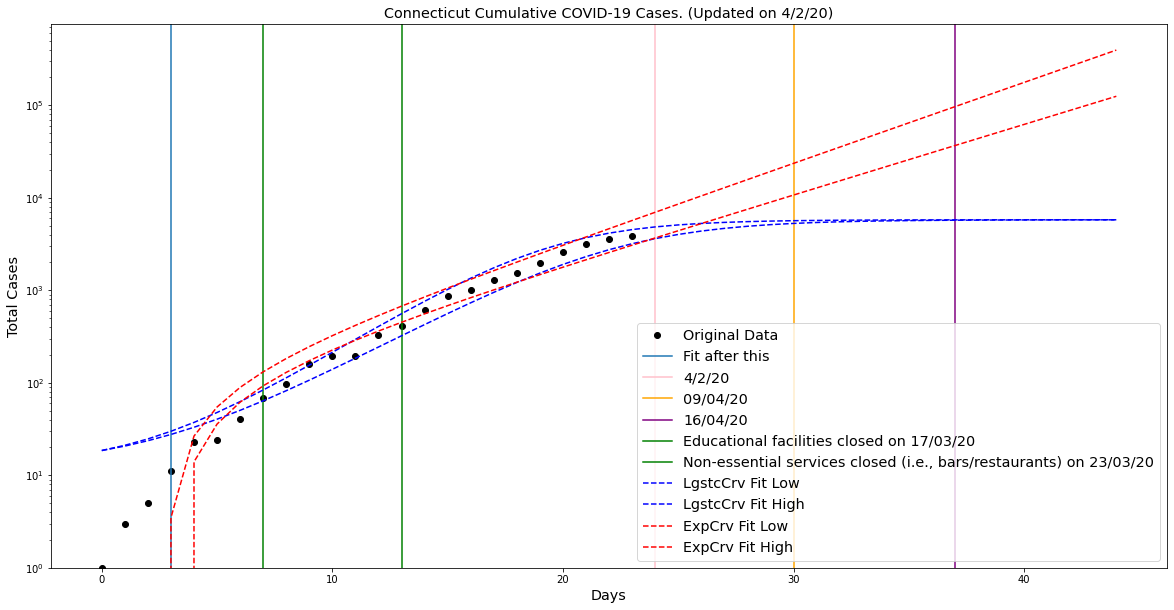



US state:  Colorado

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 3342
	Confirmed cases on 3/26/20 	 1430
	Ratio: 2.34
	Weekly increase: 133.7 %
	Daily increase: 12.9 % per day
	Doubling Time (represents recent growth): 5.7 days

** Based on Logistic Fit**

	R^2: 0.9944844631005302
	Skipping 4 days
	Doubling Time (during middle of growth):  5.2 (± 1.08 ) days

** Based on Exponential Fit **

	R^2: 0.9857394977708779
	Skipping 4 days
	Doubling Time (represents overall growth):  4.73 (± 0.74 ) days


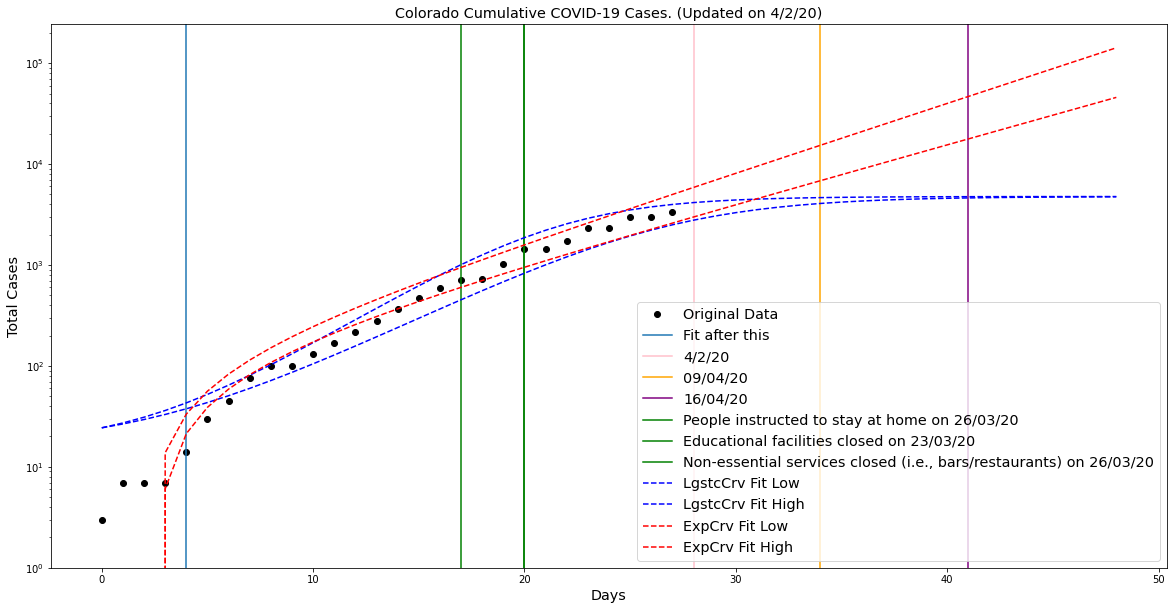



US state:  Indiana

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 3038
	Confirmed cases on 3/26/20 	 645
	Ratio: 4.71
	Weekly increase: 371.0 %
	Daily increase: 24.8 % per day
	Doubling Time (represents recent growth): 3.1 days

** Based on Logistic Fit**

	R^2: 0.9987067302287995
	Skipping 5 days
	Doubling Time (during middle of growth):  4.36 (± 0.43 ) days

** Based on Exponential Fit **

	R^2: 0.9925442124107503
	Skipping 5 days
	Doubling Time (represents overall growth):  3.53 (± 0.32 ) days


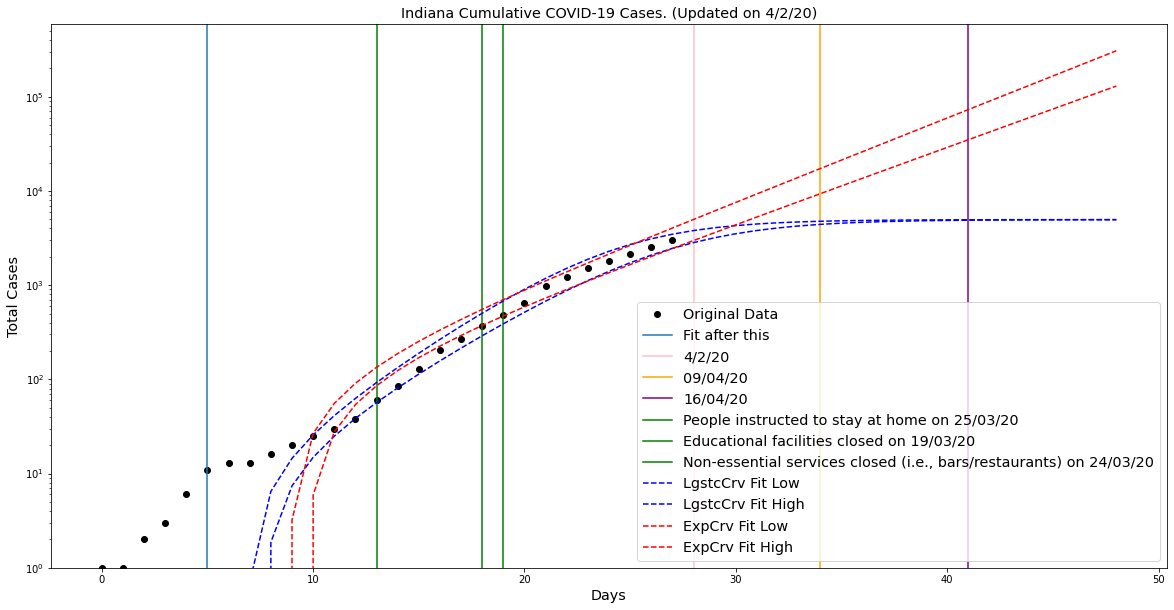



US state:  Ohio

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 2901
	Confirmed cases on 3/26/20 	 868
	Ratio: 3.34
	Weekly increase: 234.2 %
	Daily increase: 18.8 % per day
	Doubling Time (represents recent growth): 4.0 days

** Based on Logistic Fit**

	R^2: 0.9994595484103127
	Skipping 3 days
	Doubling Time (during middle of growth):  5.26 (± 0.39 ) days

** Based on Exponential Fit **

	R^2: 0.9934477135509591
	Skipping 3 days
	Doubling Time (represents overall growth):  4.17 (± 0.48 ) days


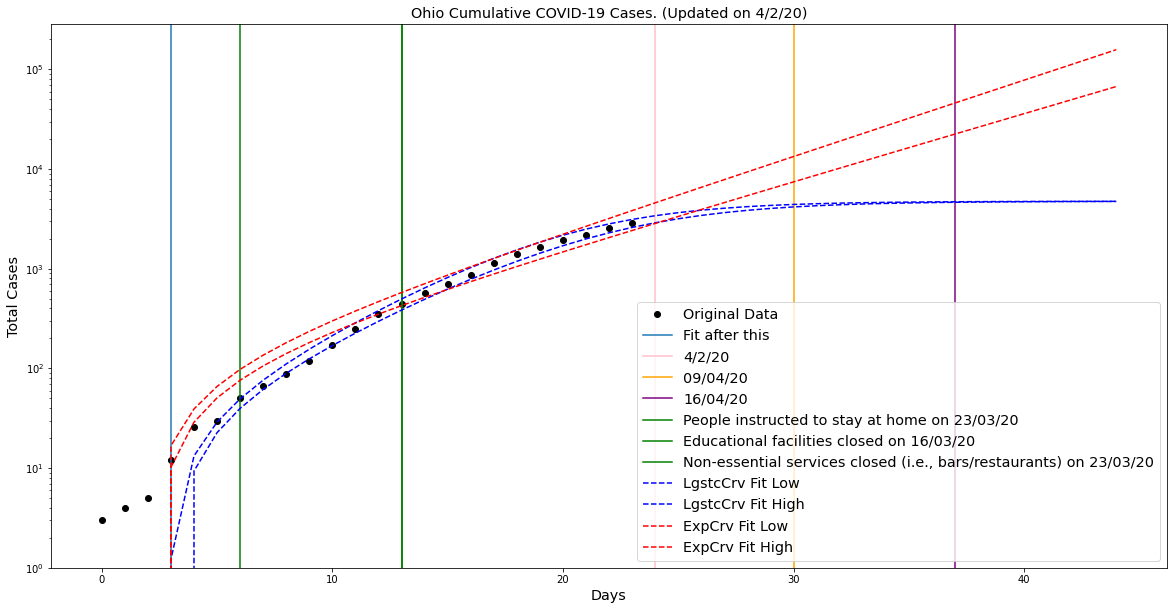



US state:  Tennessee

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 2845
	Confirmed cases on 3/26/20 	 1097
	Ratio: 2.59
	Weekly increase: 159.3 %
	Daily increase: 14.6 % per day
	Doubling Time (represents recent growth): 5.1 days

** Based on Logistic Fit**

	R^2: 0.9930976303530364
	Skipping 7 days
	Doubling Time (during middle of growth):  5.94 (± 1.7 ) days

** Based on Exponential Fit **

	R^2: 0.9865864827763198
	Skipping 7 days
	Doubling Time (represents overall growth):  4.49 (± 0.76 ) days


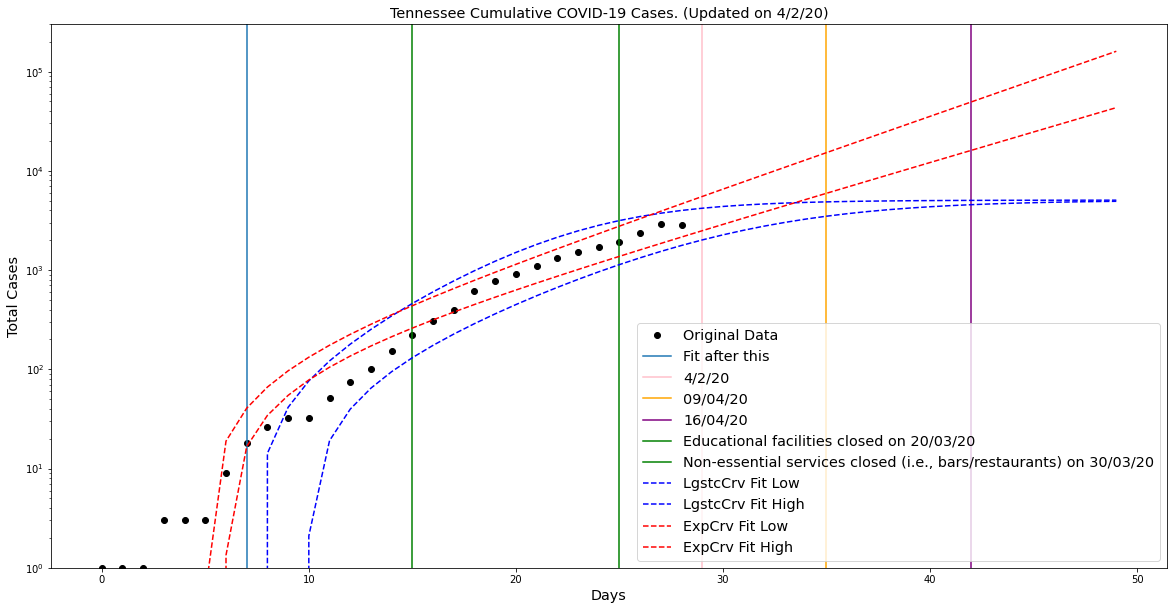



US state:  Maryland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 2331
	Confirmed cases on 3/26/20 	 583
	Ratio: 4.0
	Weekly increase: 299.8 %
	Daily increase: 21.9 % per day
	Doubling Time (represents recent growth): 3.5 days

** Based on Logistic Fit**

	R^2: 0.9988338355554891
	Skipping 6 days
	Doubling Time (during middle of growth):  5.1 (± 0.58 ) days

** Based on Exponential Fit **

	R^2: 0.9948156283610432
	Skipping 6 days
	Doubling Time (represents overall growth):  3.9 (± 0.3 ) days


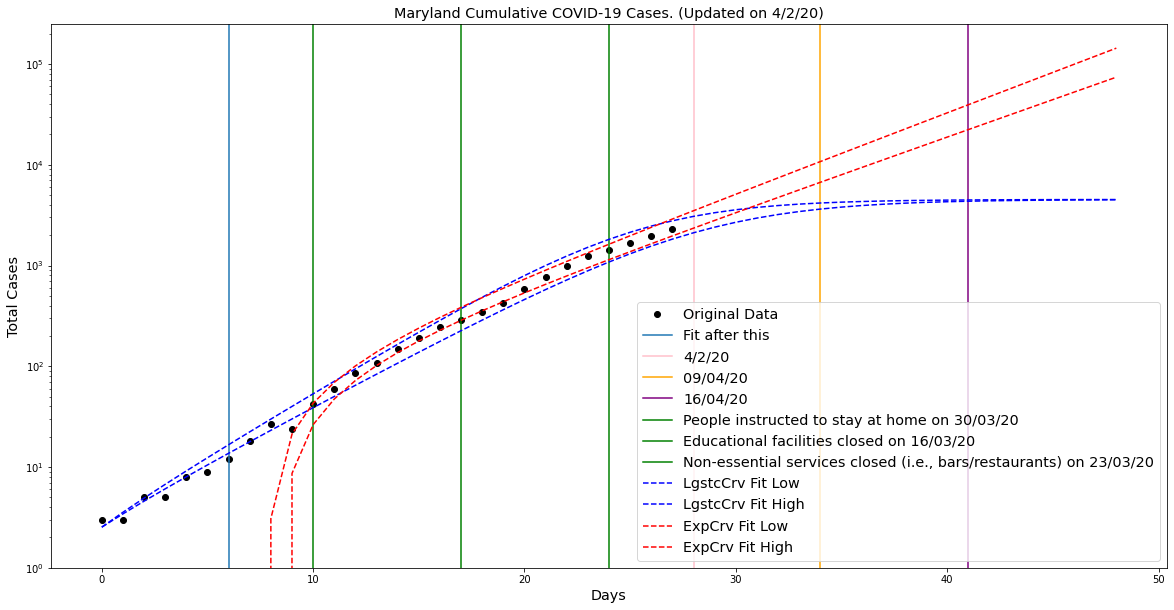



US state:  North Carolina

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 1977
	Confirmed cases on 3/26/20 	 738
	Ratio: 2.68
	Weekly increase: 167.9 %
	Daily increase: 15.1 % per day
	Doubling Time (represents recent growth): 4.9 days

** Based on Exponential Fit **

	R^2: 0.9924312359962313
	Skipping 9 days
	Doubling Time (represents overall growth):  4.85 (± 0.55 ) days


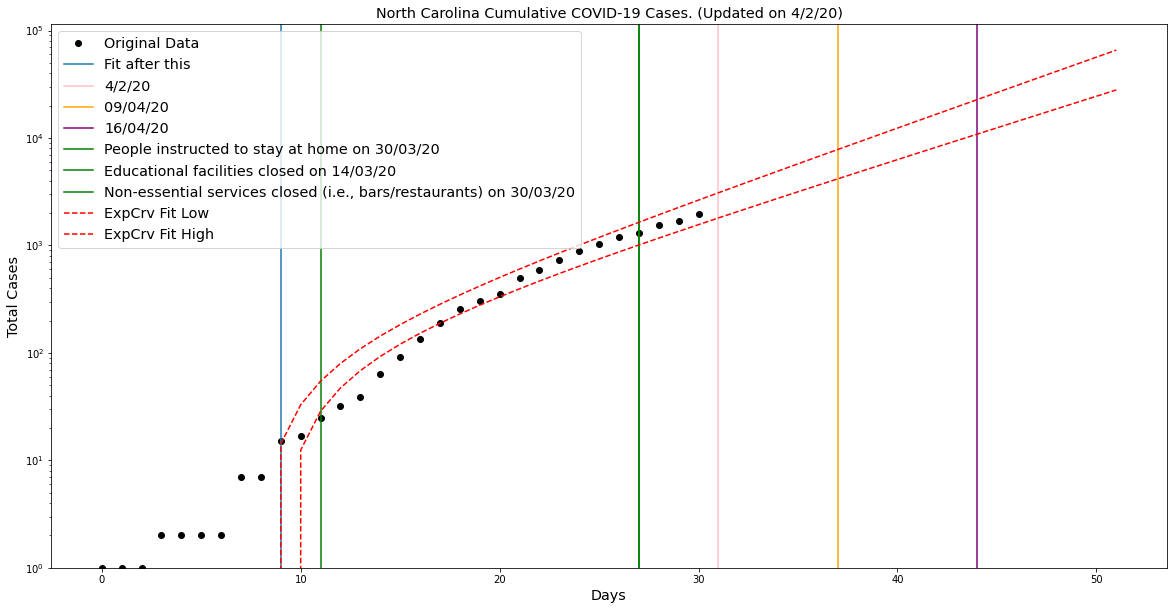



US state:  Missouri

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 1857
	Confirmed cases on 3/26/20 	 520
	Ratio: 3.57
	Weekly increase: 257.1 %
	Daily increase: 19.9 % per day
	Doubling Time (represents recent growth): 3.8 days

** Based on Exponential Fit **

	R^2: 0.9903123408042167
	Skipping 9 days
	Doubling Time (represents overall growth):  3.87 (± 0.59 ) days


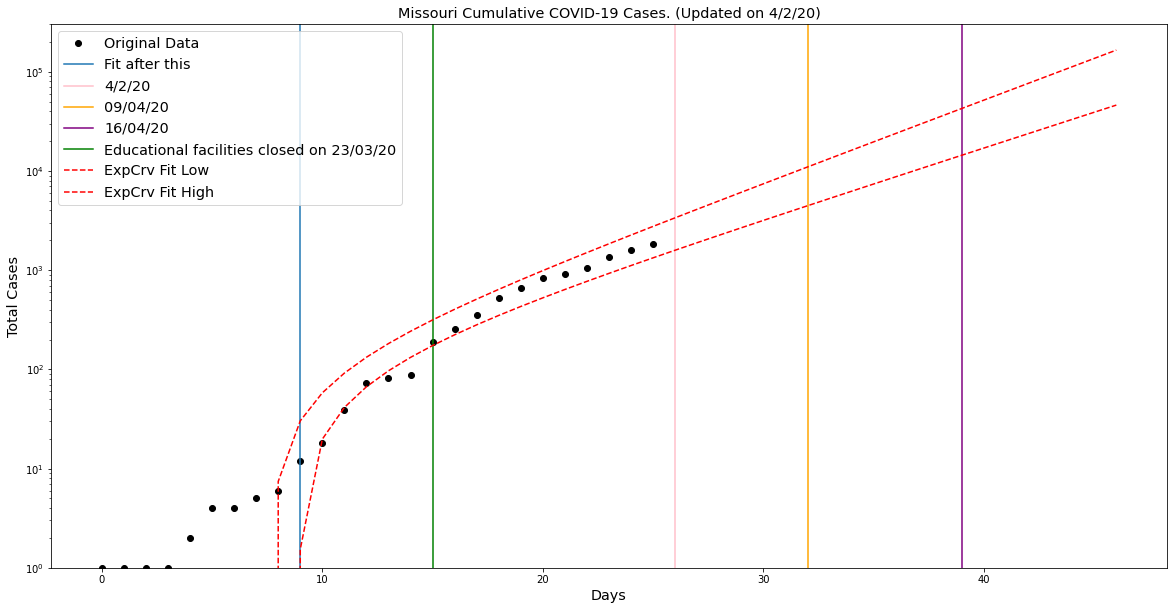



US state:  Wisconsin

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 1748
	Confirmed cases on 3/26/20 	 728
	Ratio: 2.4
	Weekly increase: 140.1 %
	Daily increase: 13.3 % per day
	Doubling Time (represents recent growth): 5.5 days

** Based on Logistic Fit**

	R^2: 0.9973285322551059
	Skipping 3 days
	Doubling Time (during middle of growth):  6.51 (± 1.27 ) days

** Based on Exponential Fit **

	R^2: 0.9875630900515477
	Skipping 3 days
	Doubling Time (represents overall growth):  5.37 (± 1.03 ) days


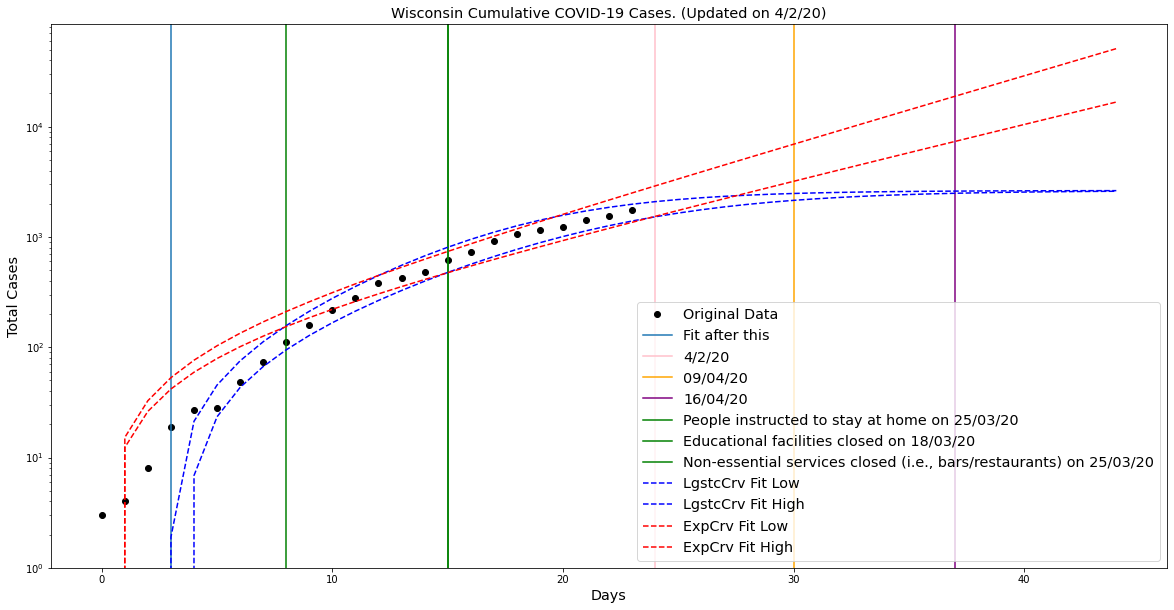



US state:  Arizona

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 1715
	Confirmed cases on 3/26/20 	 508
	Ratio: 3.38
	Weekly increase: 237.6 %
	Daily increase: 19.0 % per day
	Doubling Time (represents recent growth): 4.0 days

** Based on Exponential Fit **

	R^2: 0.950922493486963
	Skipping 48 days
	Doubling Time (represents overall growth):  4.21 (± 0.49 ) days


/Users/michaelorenstein/Virtualenvs/jupyter/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


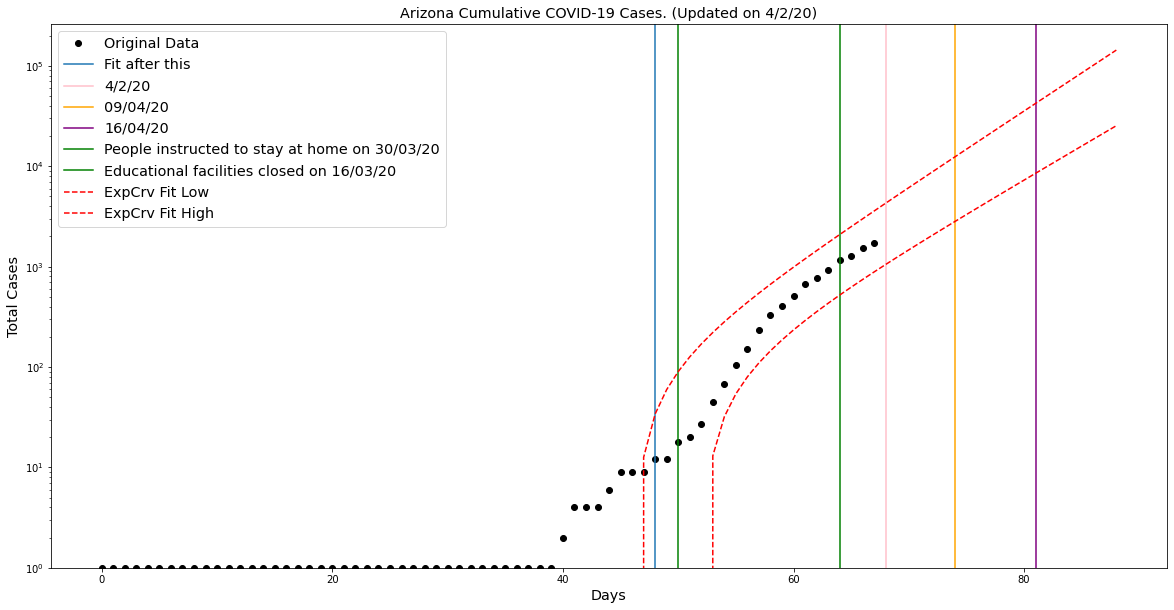



US state:  Virginia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 1706
	Confirmed cases on 3/26/20 	 466
	Ratio: 3.66
	Weekly increase: 266.1 %
	Daily increase: 20.4 % per day
	Doubling Time (represents recent growth): 3.7 days

** Based on Logistic Fit**

	R^2: 0.9994838672070895
	Skipping 4 days
	Doubling Time (during middle of growth):  5.96 (± 0.51 ) days

** Based on Exponential Fit **

	R^2: 0.998050240354861
	Skipping 4 days
	Doubling Time (represents overall growth):  4.05 (± 0.21 ) days


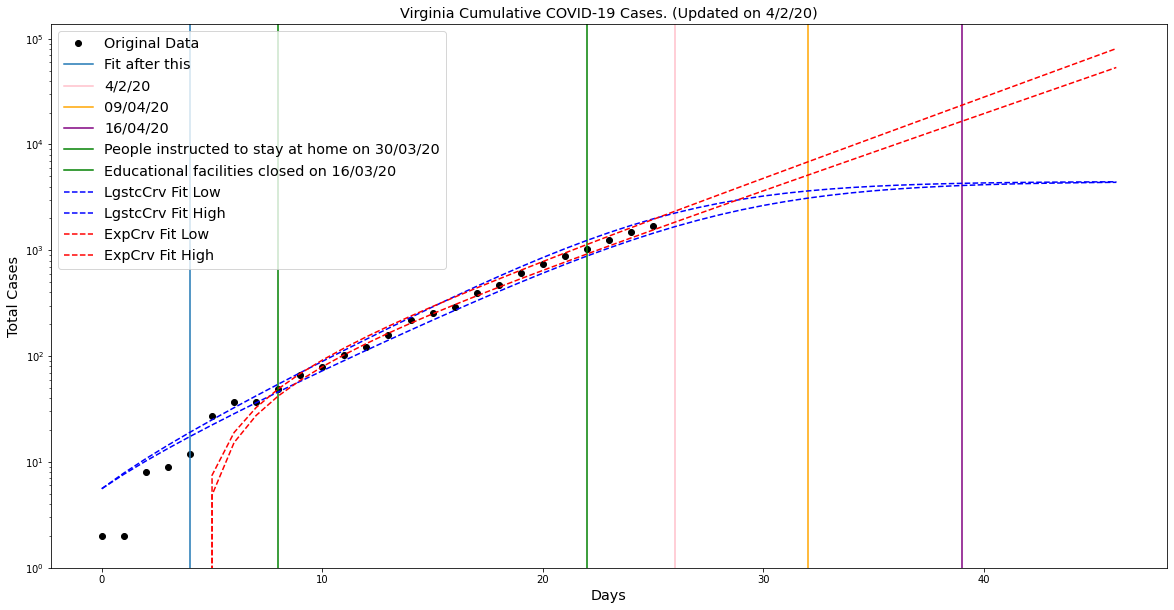



US state:  South Carolina

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 1554
	Confirmed cases on 3/26/20 	 424
	Ratio: 3.67
	Weekly increase: 266.5 %
	Daily increase: 20.4 % per day
	Doubling Time (represents recent growth): 3.7 days

** Based on Exponential Fit **

	R^2: 0.9964947115964498
	Skipping 7 days
	Doubling Time (represents overall growth):  4.41 (± 0.28 ) days


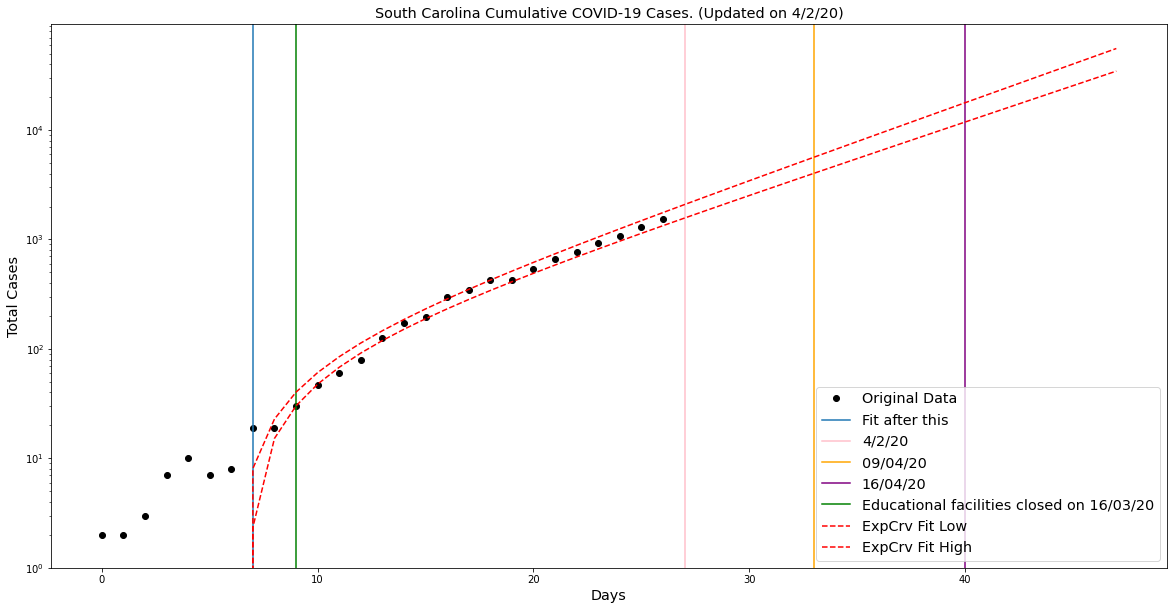



US state:  Nevada

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 1463
	Confirmed cases on 3/26/20 	 420
	Ratio: 3.48
	Weekly increase: 248.3 %
	Daily increase: 19.5 % per day
	Doubling Time (represents recent growth): 3.9 days

** Based on Exponential Fit **

	R^2: 0.9877642421888267
	Skipping 8 days
	Doubling Time (represents overall growth):  4.53 (± 0.63 ) days


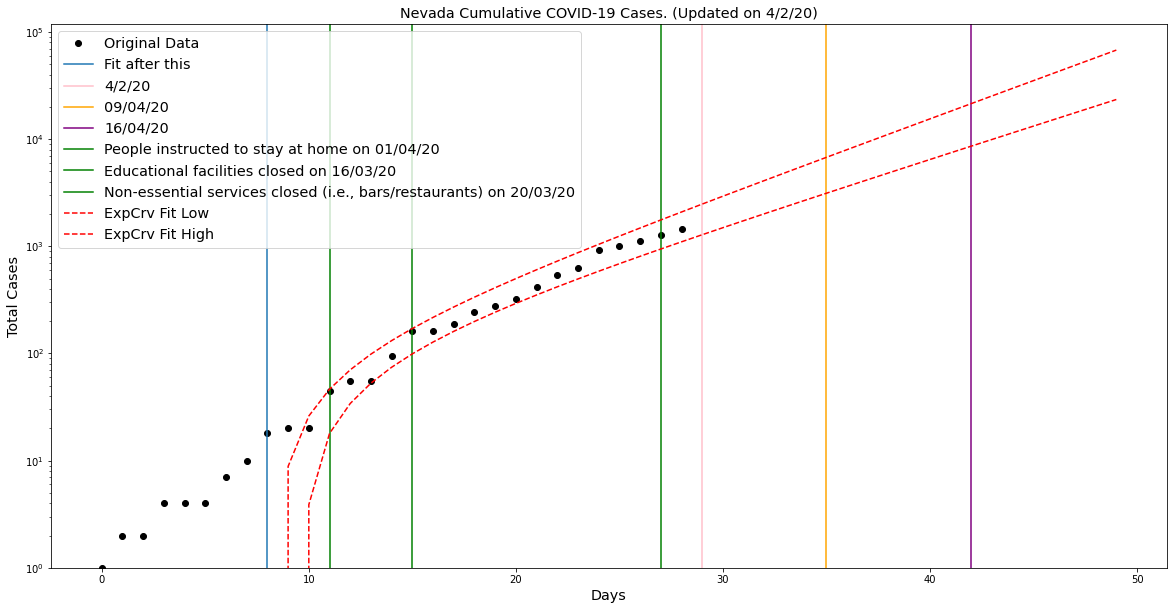



US state:  Alabama

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 1233
	Confirmed cases on 3/26/20 	 517
	Ratio: 2.38
	Weekly increase: 138.5 %
	Daily increase: 13.2 % per day
	Doubling Time (represents recent growth): 5.6 days

** Based on Logistic Fit**

	R^2: 0.9961535565264107
	Skipping 2 days
	Doubling Time (during middle of growth):  4.34 (± 0.85 ) days

** Based on Exponential Fit **

	R^2: 0.9813736824733773
	Skipping 2 days
	Doubling Time (represents overall growth):  5.12 (± 1.31 ) days


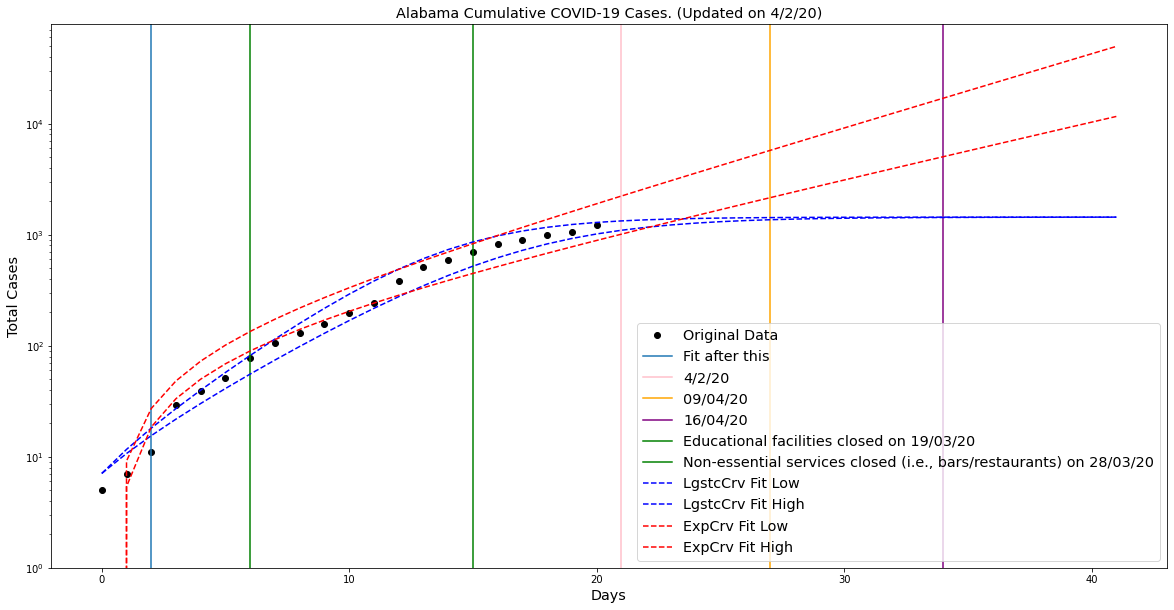



US state:  Mississippi

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 1177
	Confirmed cases on 3/26/20 	 485
	Ratio: 2.43
	Weekly increase: 142.7 %
	Daily increase: 13.5 % per day
	Doubling Time (represents recent growth): 5.5 days

** Based on Logistic Fit**

	R^2: 0.9958520522743068
	Skipping 4 days
	Doubling Time (during middle of growth):  6.57 (± 1.22 ) days

** Based on Exponential Fit **

	R^2: 0.9880568421684387
	Skipping 4 days
	Doubling Time (represents overall growth):  5.26 (± 1.24 ) days


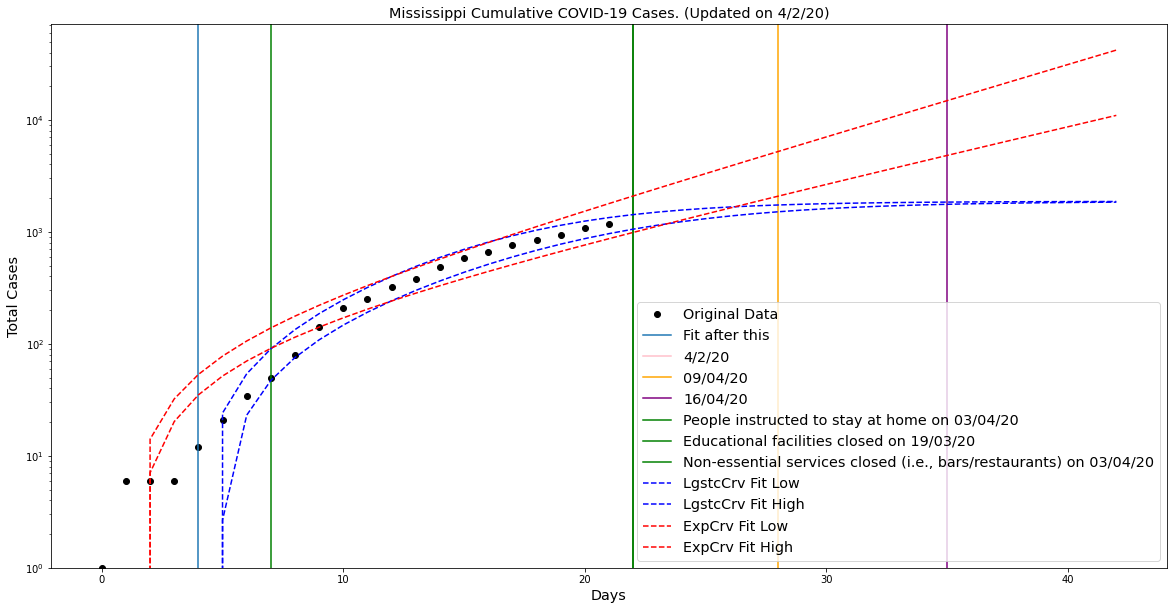



US state:  Utah

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 1092
	Confirmed cases on 3/26/20 	 396
	Ratio: 2.76
	Weekly increase: 175.8 %
	Daily increase: 15.6 % per day
	Doubling Time (represents recent growth): 4.8 days

** Based on Logistic Fit**

	R^2: 0.9948361185503147
	Skipping 8 days
	Doubling Time (during middle of growth):  5.42 (± 1.58 ) days

** Based on Exponential Fit **

	R^2: 0.9847963274593263
	Skipping 8 days
	Doubling Time (represents overall growth):  5.39 (± 1.25 ) days


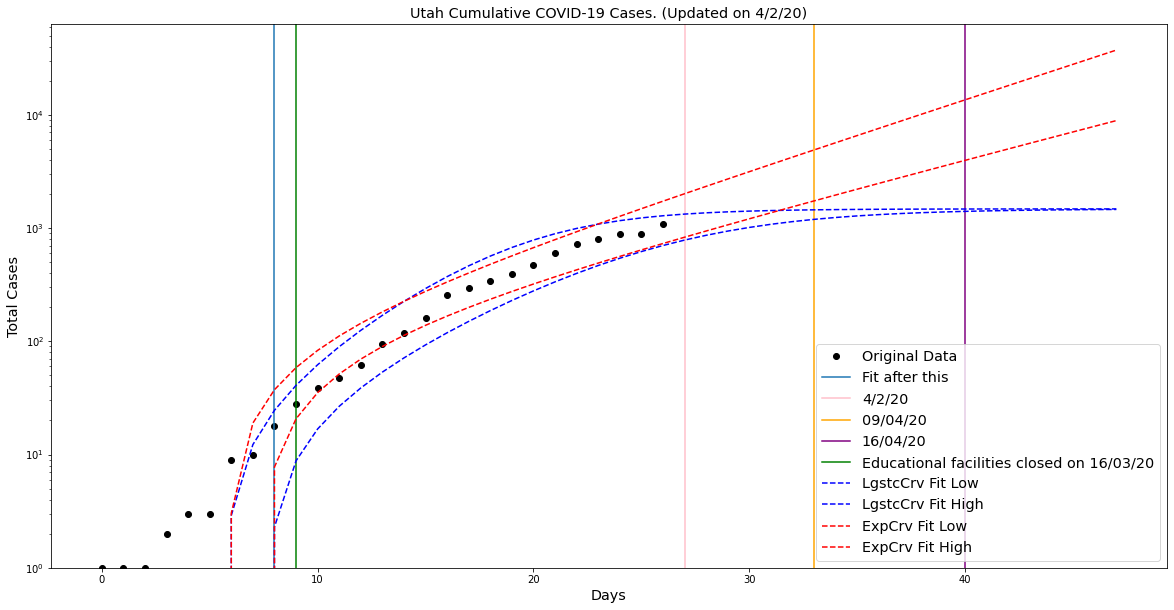



US state:  Oklahoma

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 881
	Confirmed cases on 3/26/20 	 248
	Ratio: 3.55
	Weekly increase: 255.2 %
	Daily increase: 19.9 % per day
	Doubling Time (represents recent growth): 3.8 days

** Based on Exponential Fit **

	R^2: 0.9846701412029988
	Skipping 10 days
	Doubling Time (represents overall growth):  4.14 (± 0.65 ) days


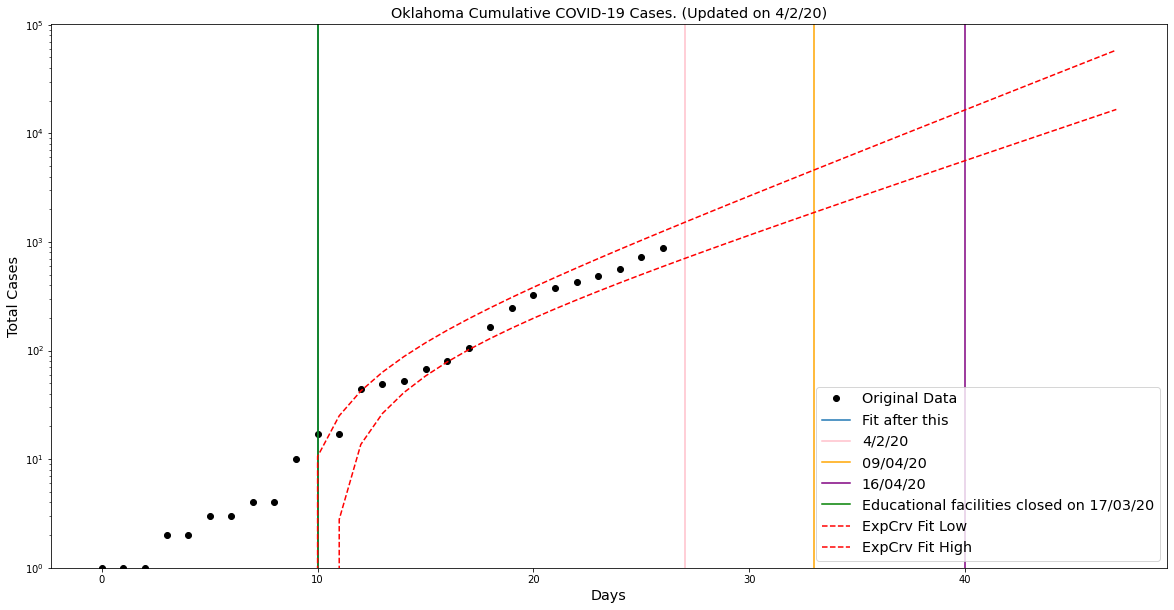



US state:  Oregon

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 826
	Confirmed cases on 3/26/20 	 316
	Ratio: 2.61
	Weekly increase: 161.4 %
	Daily increase: 14.7 % per day
	Doubling Time (represents recent growth): 5.0 days

** Based on Exponential Fit **

	R^2: 0.9895389874573737
	Skipping 8 days
	Doubling Time (represents overall growth):  5.47 (± 0.61 ) days


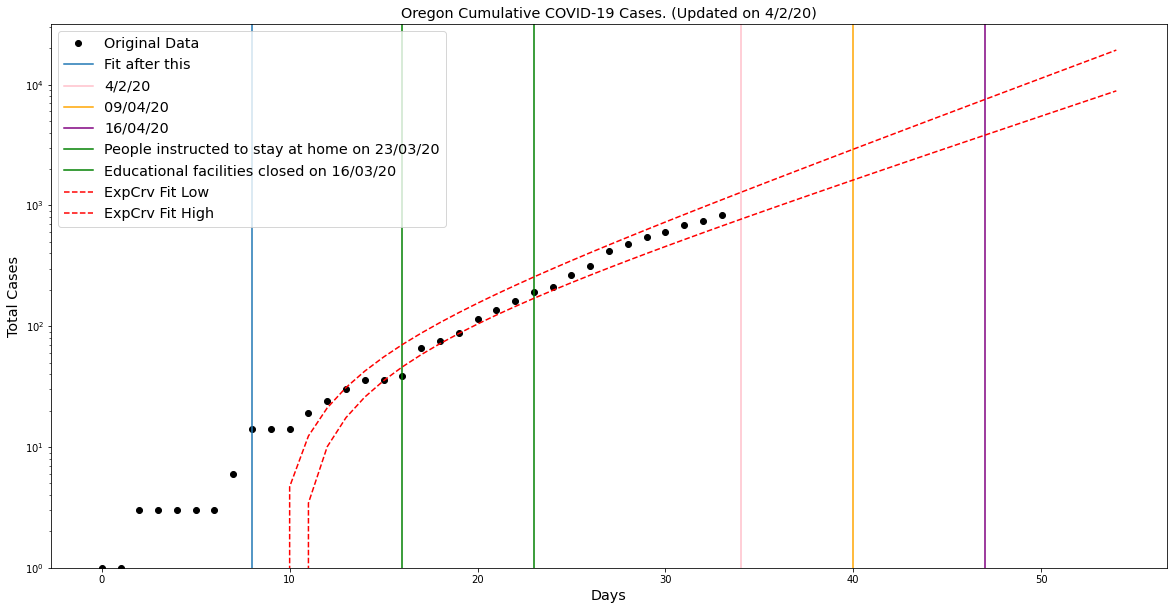



US state:  Idaho

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 776
	Confirmed cases on 3/26/20 	 146
	Ratio: 5.32
	Weekly increase: 431.5 %
	Daily increase: 27.0 % per day
	Doubling Time (represents recent growth): 2.9 days

** Based on Exponential Fit **

	R^2: 0.9940788911331759
	Skipping 6 days
	Doubling Time (represents overall growth):  2.88 (± 0.4 ) days


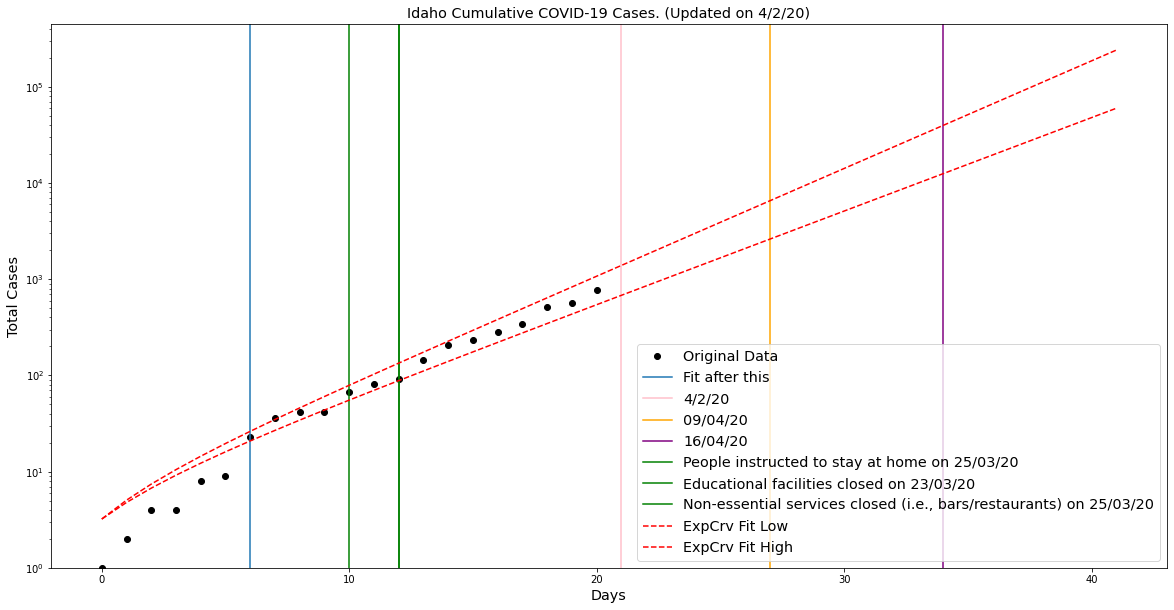



US state:  Kentucky

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 770
	Confirmed cases on 3/26/20 	 247
	Ratio: 3.12
	Weekly increase: 211.7 %
	Daily increase: 17.6 % per day
	Doubling Time (represents recent growth): 4.3 days

** Based on Exponential Fit **

	R^2: 0.9880771005931152
	Skipping 7 days
	Doubling Time (represents overall growth):  4.85 (± 0.63 ) days


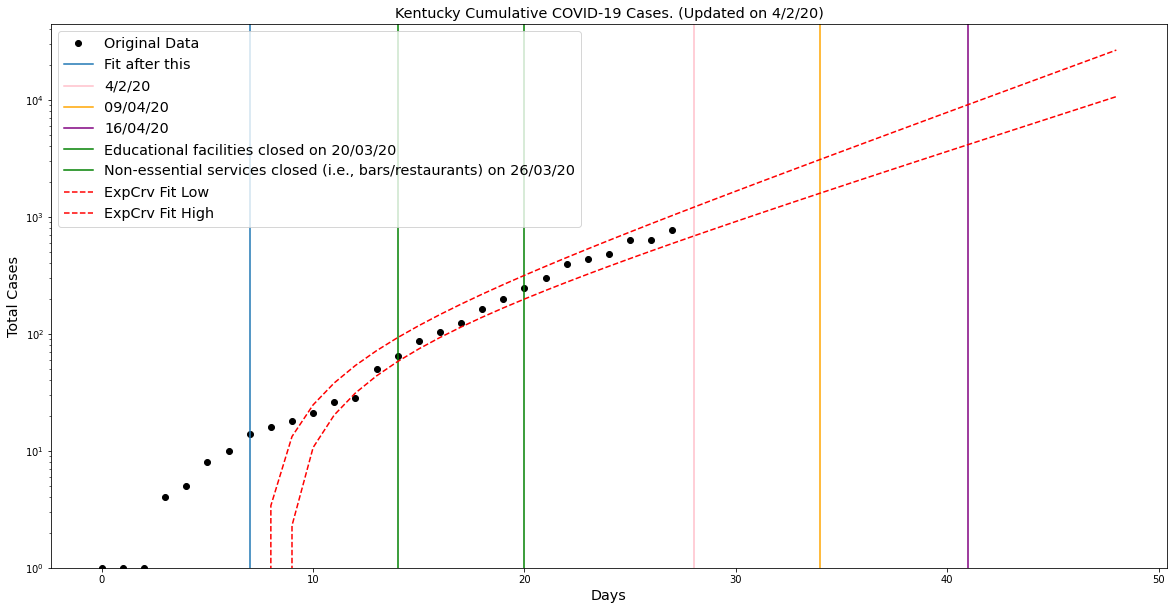



US state:  Minnesota

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 742
	Confirmed cases on 3/26/20 	 344
	Ratio: 2.16
	Weekly increase: 115.7 %
	Daily increase: 11.6 % per day
	Doubling Time (represents recent growth): 6.3 days

** Based on Logistic Fit**

	R^2: 0.9982963501401997
	Skipping 7 days
	Doubling Time (during middle of growth):  7.2 (± 1.08 ) days

** Based on Exponential Fit **

	R^2: 0.9916849728494258
	Skipping 7 days
	Doubling Time (represents overall growth):  6.72 (± 0.94 ) days


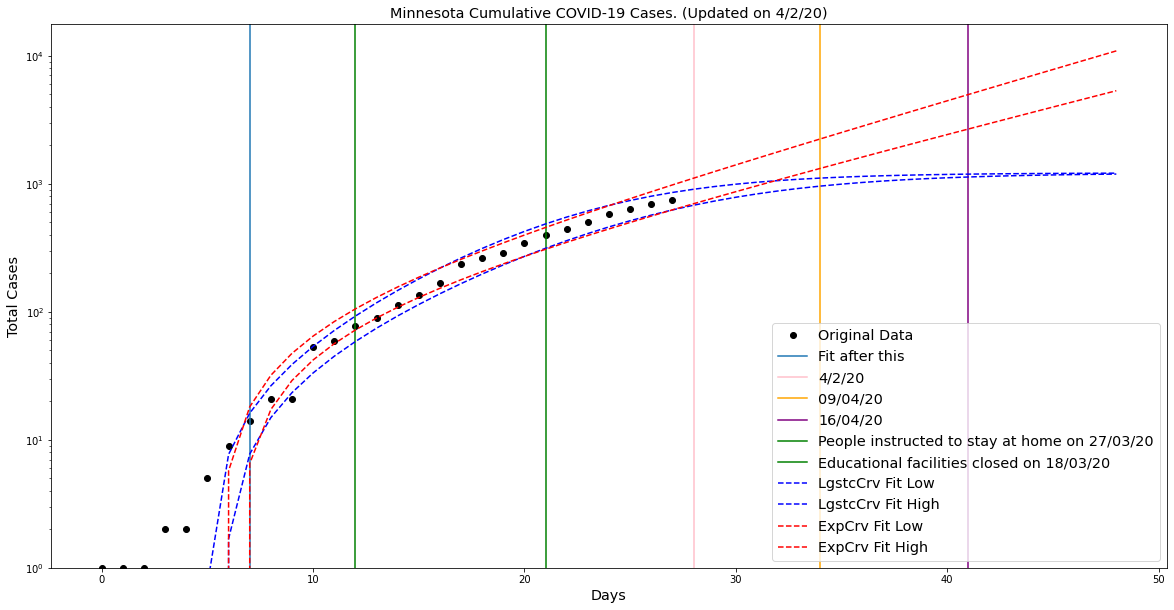



US state:  Rhode Island

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 657
	Confirmed cases on 3/26/20 	 165
	Ratio: 3.98
	Weekly increase: 298.2 %
	Daily increase: 21.8 % per day
	Doubling Time (represents recent growth): 3.5 days

** Based on Exponential Fit **

	R^2: 0.9966521019639547
	Skipping 12 days
	Doubling Time (represents overall growth):  3.61 (± 0.29 ) days


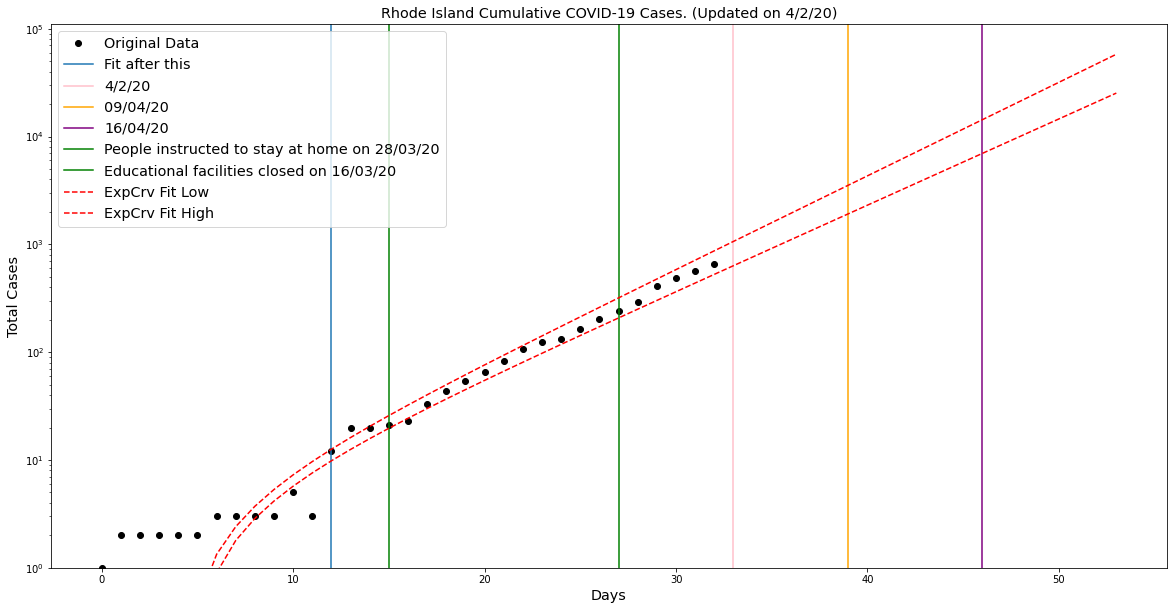



US state:  District of Columbia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 653
	Confirmed cases on 3/26/20 	 231
	Ratio: 2.83
	Weekly increase: 182.7 %
	Daily increase: 16.0 % per day
	Doubling Time (represents recent growth): 4.7 days

** Based on Logistic Fit**

	R^2: 0.9971239088301779
	Skipping 0 days
	Doubling Time (during middle of growth):  10.46 (± 3.39 ) days

** Based on Exponential Fit **

	R^2: 0.997123908990894
	Skipping 0 days
	Doubling Time (represents overall growth):  5.23 (± 0.57 ) days


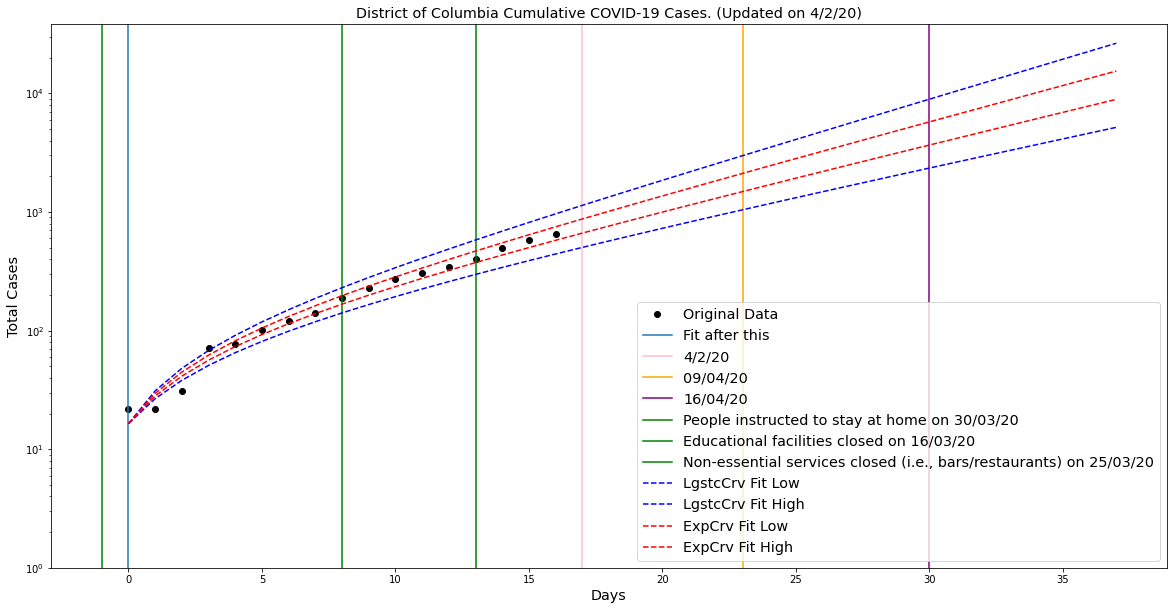



US state:  Arkansas

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 643
	Confirmed cases on 3/26/20 	 335
	Ratio: 1.92
	Weekly increase: 91.9 %
	Daily increase: 9.8 % per day
	Doubling Time (represents recent growth): 7.4 days

** Based on Exponential Fit **

	R^2: 0.9774212575314213
	Skipping 1 days
	Doubling Time (represents overall growth):  6.74 (± 2.14 ) days


/Users/michaelorenstein/Virtualenvs/jupyter/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


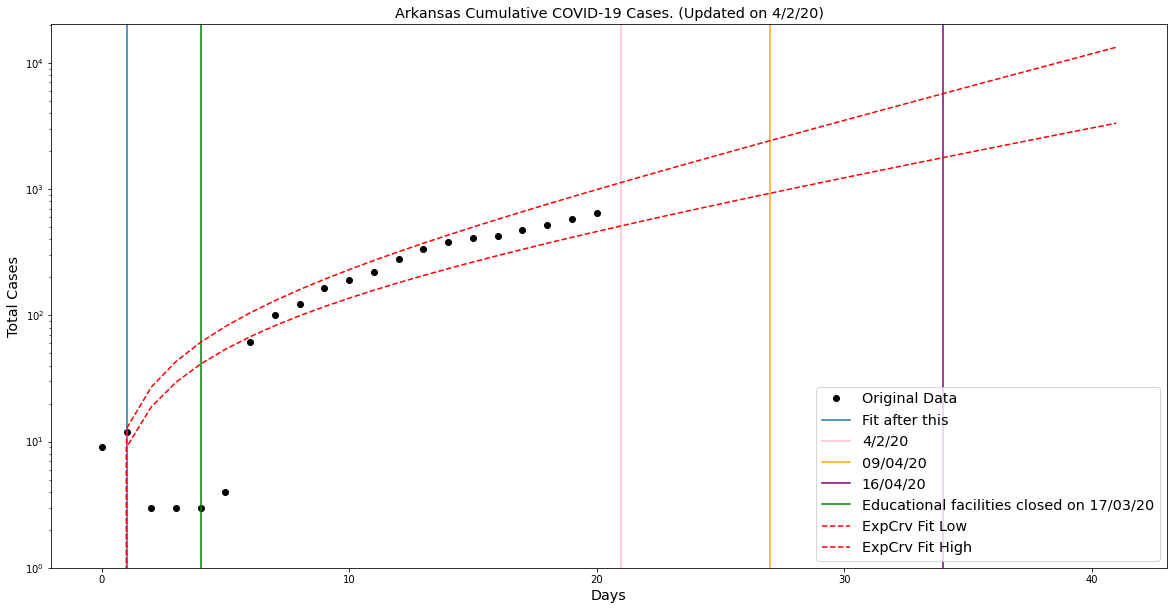



US state:  Iowa

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 614
	Confirmed cases on 3/26/20 	 179
	Ratio: 3.43
	Weekly increase: 243.0 %
	Daily increase: 19.3 % per day
	Doubling Time (represents recent growth): 3.9 days

** Based on Logistic Fit**

	R^2: 0.9984585756055805
	Skipping 2 days
	Doubling Time (during middle of growth):  4.85 (± 0.51 ) days

** Based on Exponential Fit **

	R^2: 0.9932152733379651
	Skipping 2 days
	Doubling Time (represents overall growth):  4.33 (± 0.44 ) days


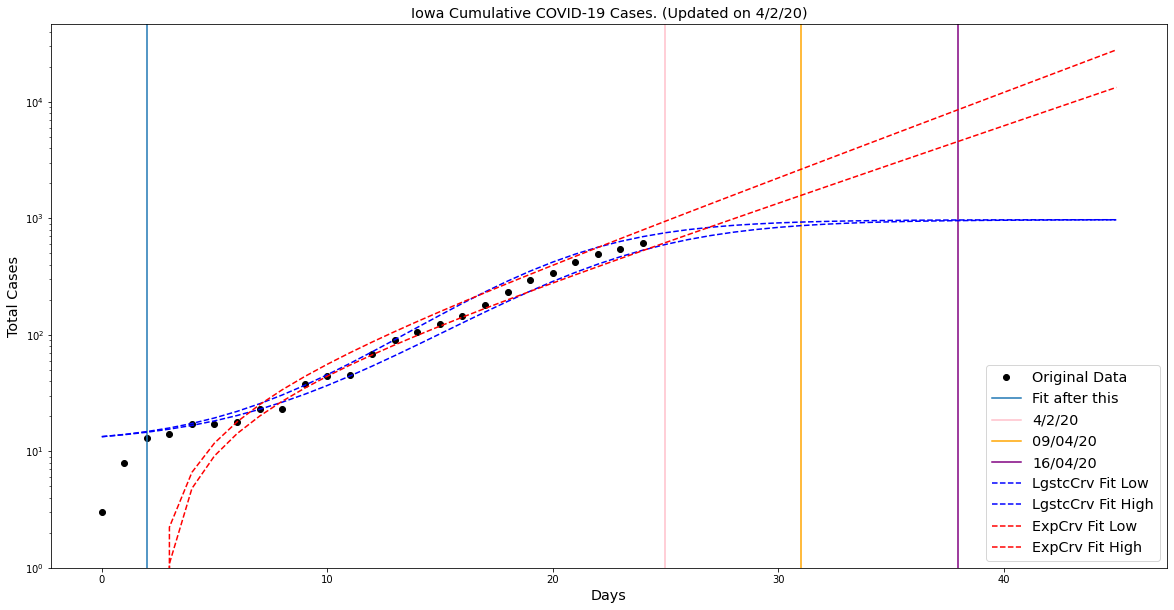



US state:  Kansas

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 553
	Confirmed cases on 3/26/20 	 172
	Ratio: 3.22
	Weekly increase: 221.5 %
	Daily increase: 18.2 % per day
	Doubling Time (represents recent growth): 4.2 days

** Based on Exponential Fit **

	R^2: 0.984811713635736
	Skipping 8 days
	Doubling Time (represents overall growth):  4.99 (± 0.69 ) days


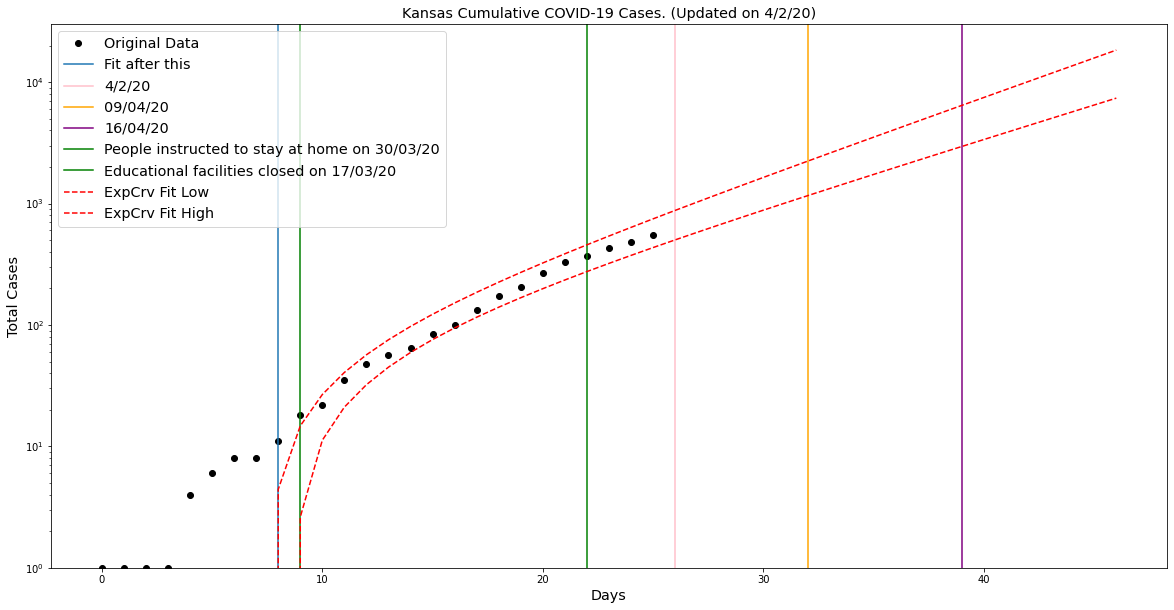



US state:  Delaware

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 393
	Confirmed cases on 3/26/20 	 130
	Ratio: 3.02
	Weekly increase: 202.3 %
	Daily increase: 17.1 % per day
	Doubling Time (represents recent growth): 4.4 days

** Based on Exponential Fit **

	R^2: 0.9885785492151686
	Skipping 6 days
	Doubling Time (represents overall growth):  5.79 (± 0.94 ) days


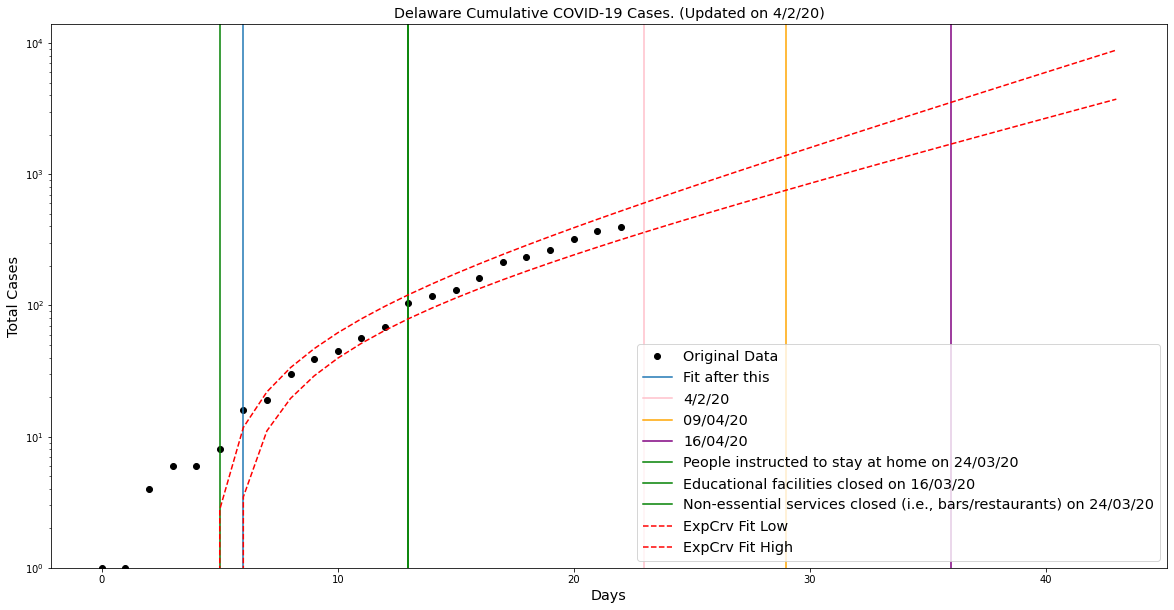



US state:  New Mexico

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 388
	Confirmed cases on 3/26/20 	 113
	Ratio: 3.43
	Weekly increase: 243.4 %
	Daily increase: 19.3 % per day
	Doubling Time (represents recent growth): 3.9 days

** Based on Logistic Fit**

	R^2: 0.9918093751543272
	Skipping 3 days
	Doubling Time (during middle of growth):  6.24 (± 2.51 ) days

** Based on Exponential Fit **

	R^2: 0.9904300947085719
	Skipping 3 days
	Doubling Time (represents overall growth):  4.85 (± 0.77 ) days


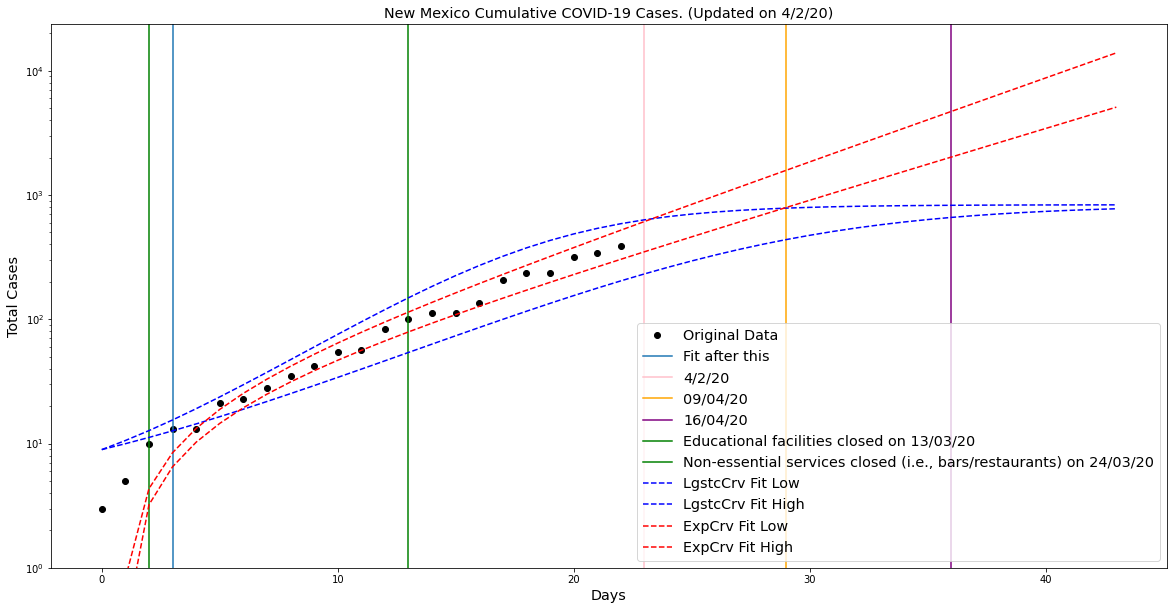



US state:  Maine

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 376
	Confirmed cases on 3/26/20 	 155
	Ratio: 2.43
	Weekly increase: 142.6 %
	Daily increase: 13.5 % per day
	Doubling Time (represents recent growth): 5.5 days

** Based on Logistic Fit**

	R^2: 0.9936606245502615
	Skipping 4 days
	Doubling Time (during middle of growth):  10.3 (± 9.35 ) days

** Based on Exponential Fit **

	R^2: 0.9923692551250444
	Skipping 4 days
	Doubling Time (represents overall growth):  8.16 (± 2.01 ) days


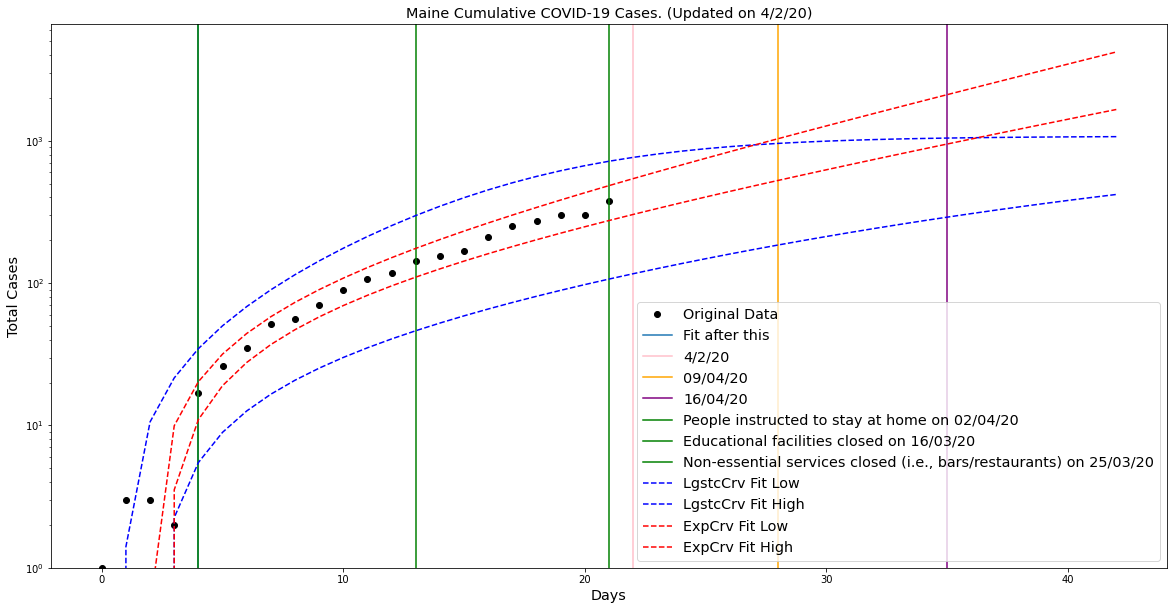



US state:  Vermont

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 338
	Confirmed cases on 3/26/20 	 158
	Ratio: 2.14
	Weekly increase: 113.9 %
	Daily increase: 11.5 % per day
	Doubling Time (represents recent growth): 6.4 days

** Based on Logistic Fit**

	R^2: 0.9979686238195189
	Skipping 8 days
	Doubling Time (during middle of growth):  4.82 (± 0.74 ) days

** Based on Exponential Fit **

	R^2: 0.9576008283029198
	Skipping 8 days
	Doubling Time (represents overall growth):  7.63 (± 2.15 ) days


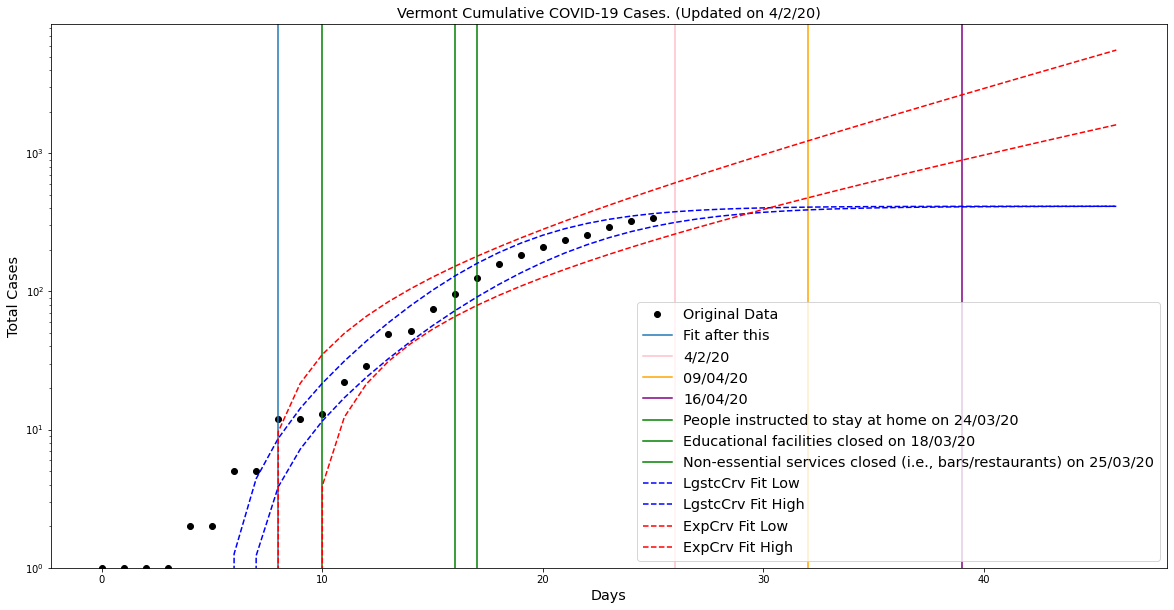



US state:  Puerto Rico

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 316
	Confirmed cases on 3/26/20 	 64
	Ratio: 4.94
	Weekly increase: 393.8 %
	Daily increase: 25.6 % per day
	Doubling Time (represents recent growth): 3.0 days

** Based on Exponential Fit **

	R^2: 0.9907789250289946
	Skipping 4 days
	Doubling Time (represents overall growth):  3.31 (± 0.66 ) days


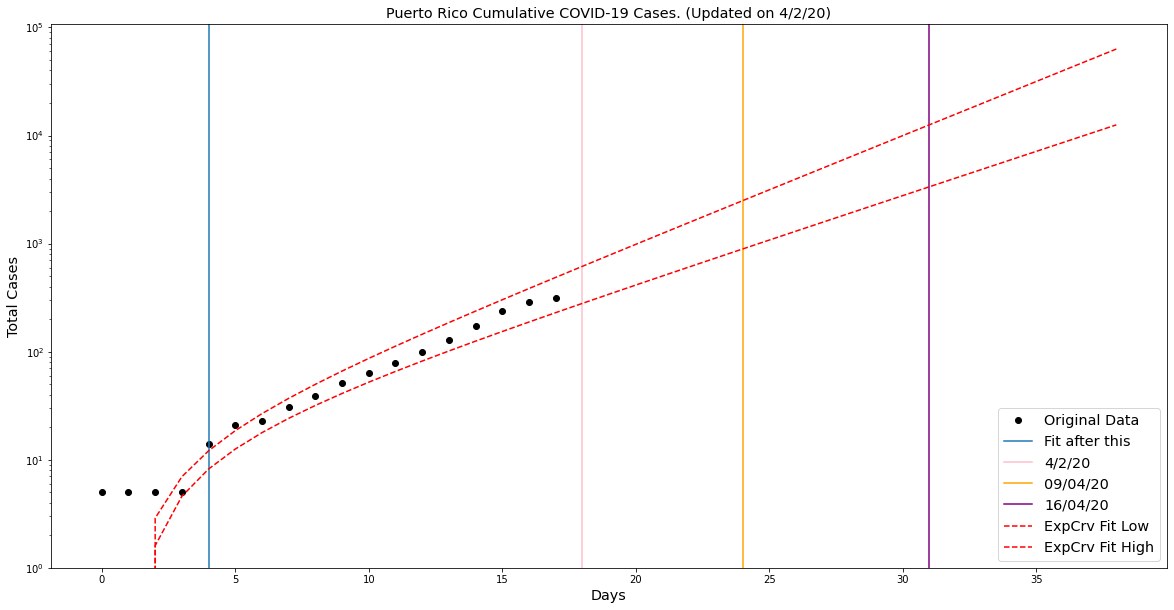



US state:  New Hampshire

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 316
	Confirmed cases on 3/26/20 	 137
	Ratio: 2.31
	Weekly increase: 130.7 %
	Daily increase: 12.7 % per day
	Doubling Time (represents recent growth): 5.8 days


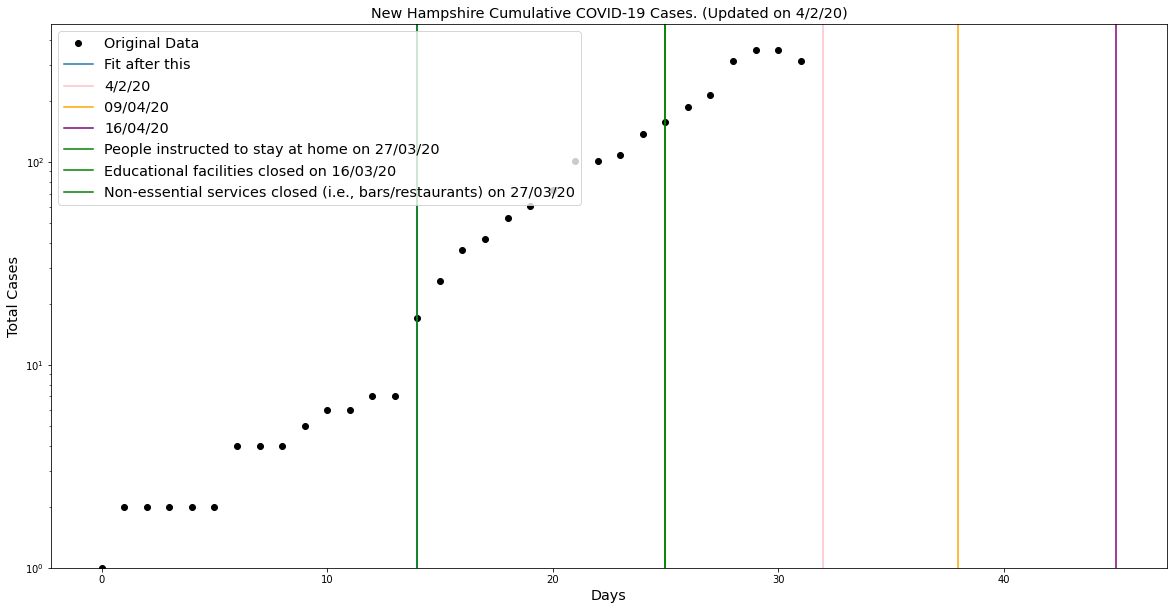



US state:  Hawaii

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 256
	Confirmed cases on 3/26/20 	 95
	Ratio: 2.69
	Weekly increase: 169.5 %
	Daily increase: 15.2 % per day
	Doubling Time (represents recent growth): 4.9 days

** Based on Exponential Fit **

	R^2: 0.968689702970392
	Skipping 11 days
	Doubling Time (represents overall growth):  7.15 (± 2.0 ) days


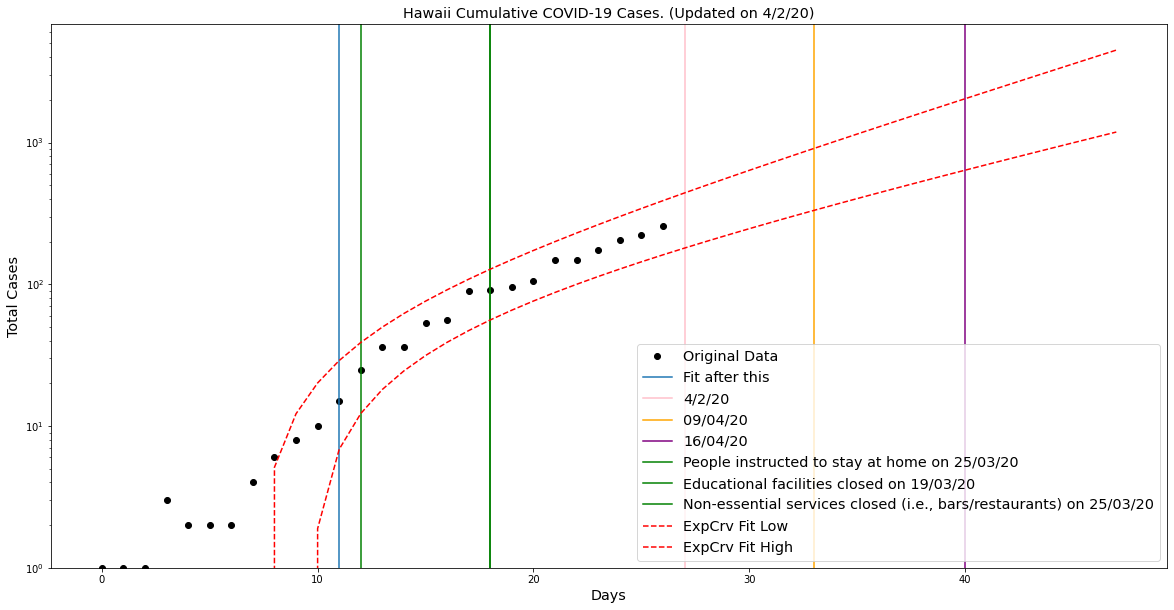



US state:  Nebraska

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 246
	Confirmed cases on 3/26/20 	 74
	Ratio: 3.32
	Weekly increase: 232.4 %
	Daily increase: 18.7 % per day
	Doubling Time (represents recent growth): 4.0 days

** Based on Exponential Fit **

	R^2: 0.9852430148529095
	Skipping 7 days
	Doubling Time (represents overall growth):  3.65 (± 0.38 ) days


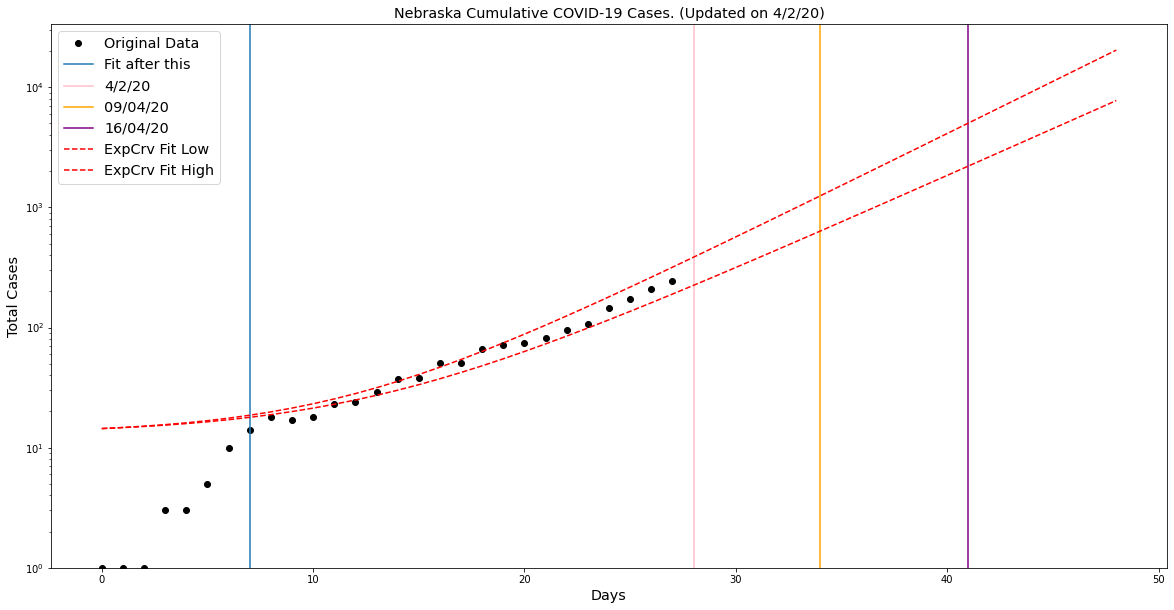



US state:  Montana

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 241
	Confirmed cases on 3/26/20 	 90
	Ratio: 2.68
	Weekly increase: 167.8 %
	Daily increase: 15.1 % per day
	Doubling Time (represents recent growth): 4.9 days

** Based on Logistic Fit**

	R^2: 0.9976853435060804
	Skipping 6 days
	Doubling Time (during middle of growth):  4.59 (± 1.19 ) days

** Based on Exponential Fit **

	R^2: 0.9559900458081427
	Skipping 6 days
	Doubling Time (represents overall growth):  7.95 (± 2.56 ) days


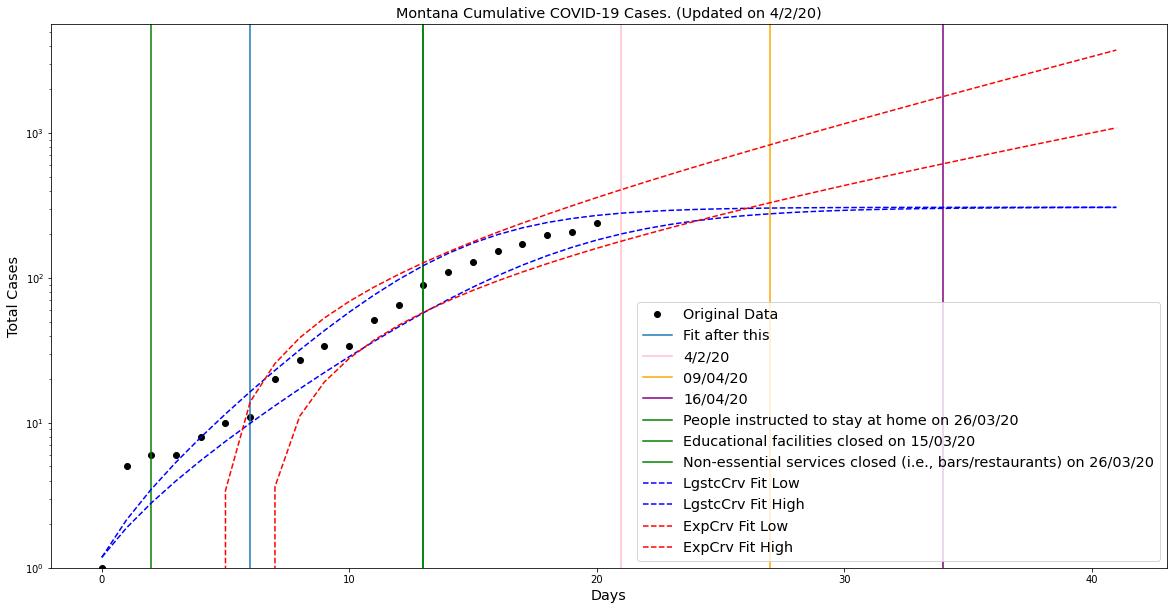



US state:  West Virginia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 216
	Confirmed cases on 3/26/20 	 52
	Ratio: 4.15
	Weekly increase: 315.4 %
	Daily increase: 22.6 % per day
	Doubling Time (represents recent growth): 3.4 days

** Based on Logistic Fit**

	R^2: 0.9978172340609512
	Skipping 3 days
	Doubling Time (during middle of growth):  3.99 (± 1.07 ) days

** Based on Exponential Fit **

	R^2: 0.9841965144579439
	Skipping 3 days
	Doubling Time (represents overall growth):  5.82 (± 1.7 ) days


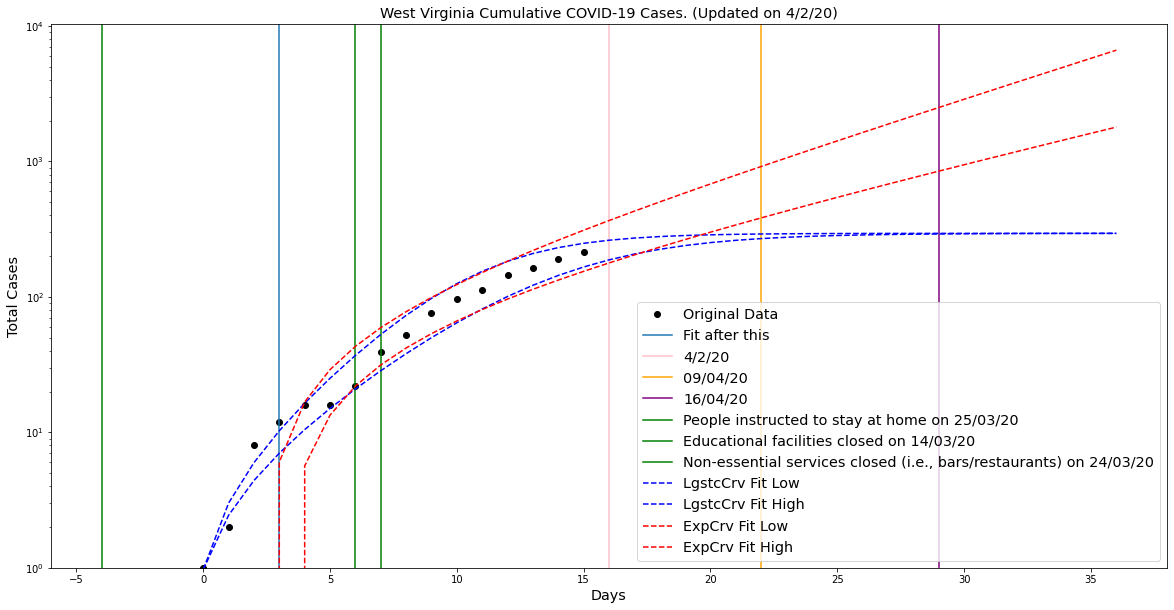



US state:  South Dakota

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 165
	Confirmed cases on 3/26/20 	 46
	Ratio: 3.59
	Weekly increase: 258.7 %
	Daily increase: 20.0 % per day
	Doubling Time (represents recent growth): 3.8 days

** Based on Exponential Fit **

	R^2: 0.9901602751822683
	Skipping 6 days
	Doubling Time (represents overall growth):  4.21 (± 0.63 ) days


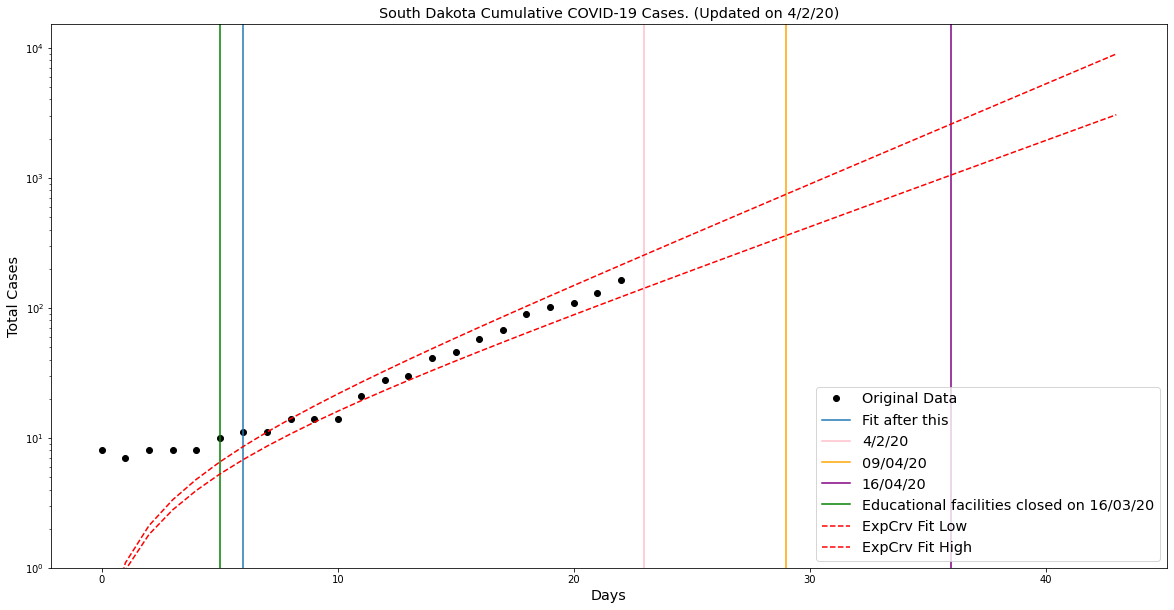



US state:  North Dakota

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 159
	Confirmed cases on 3/26/20 	 51
	Ratio: 3.12
	Weekly increase: 211.8 %
	Daily increase: 17.6 % per day
	Doubling Time (represents recent growth): 4.3 days

** Based on Exponential Fit **

	R^2: 0.9886523950248031
	Skipping 7 days
	Doubling Time (represents overall growth):  5.54 (± 1.78 ) days


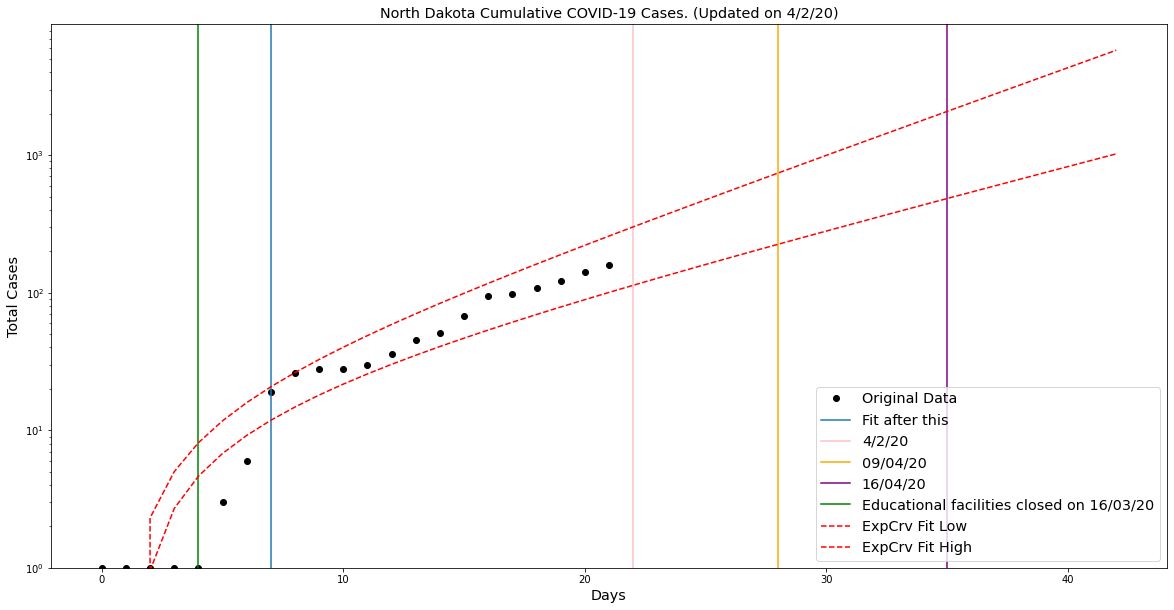



US state:  Wyoming

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 150
	Confirmed cases on 3/26/20 	 53
	Ratio: 2.83
	Weekly increase: 183.0 %
	Daily increase: 16.0 % per day
	Doubling Time (represents recent growth): 4.7 days

** Based on Exponential Fit **

	R^2: 0.9905390463445198
	Skipping 5 days
	Doubling Time (represents overall growth):  5.14 (± 1.11 ) days


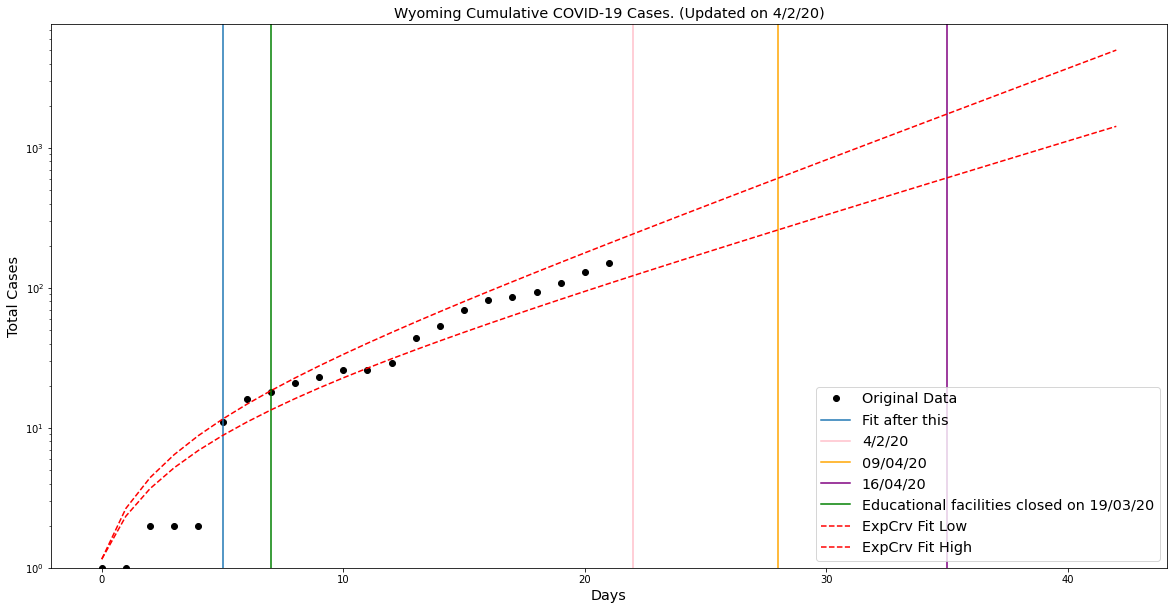



US state:  Alaska

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 143
	Confirmed cases on 3/26/20 	 56
	Ratio: 2.55
	Weekly increase: 155.4 %
	Daily increase: 14.3 % per day
	Doubling Time (represents recent growth): 5.2 days

** Based on Logistic Fit**

	R^2: 0.993677987986333
	Skipping 7 days
	Doubling Time (during middle of growth):  3.68 (± 1.24 ) days


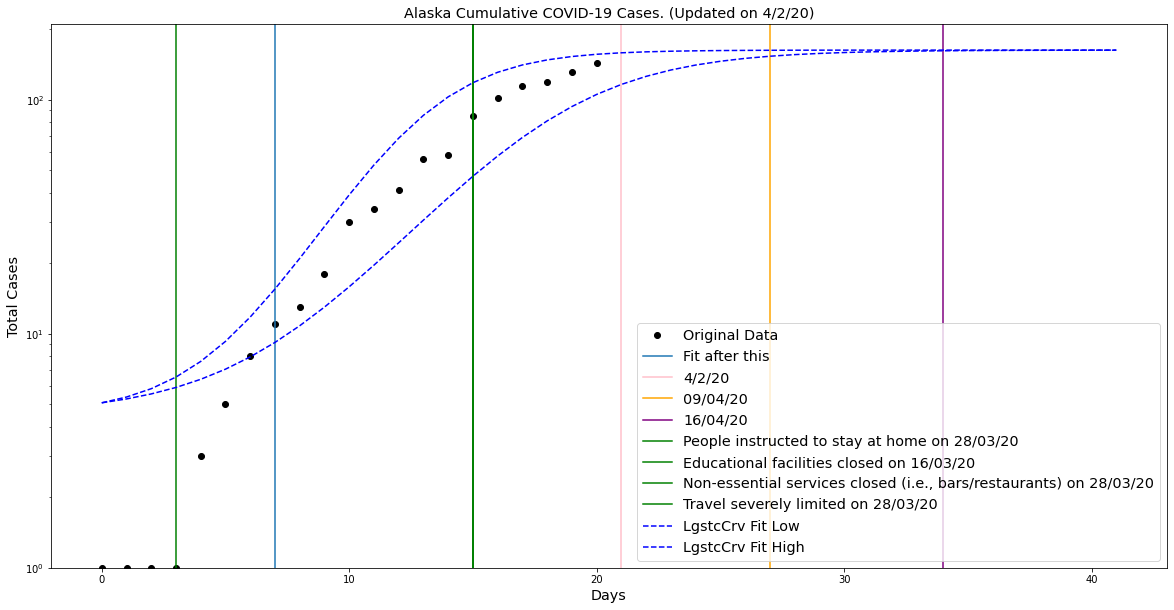



US state:  Grand Princess

** Based on Most Recent Week of Data **

	Confirmed cases on 4/2/20 	 103
	Confirmed cases on 3/26/20 	 28
	Ratio: 3.68
	Weekly increase: 267.9 %
	Daily increase: 20.5 % per day
	Doubling Time (represents recent growth): 3.7 days

** Based on Logistic Fit**

	R^2: 0.9945187019571118
	Skipping 0 days
	Doubling Time (during middle of growth):  0.13 (± 2.57 ) days


/Users/michaelorenstein/Virtualenvs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/Users/michaelorenstein/Virtualenvs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  


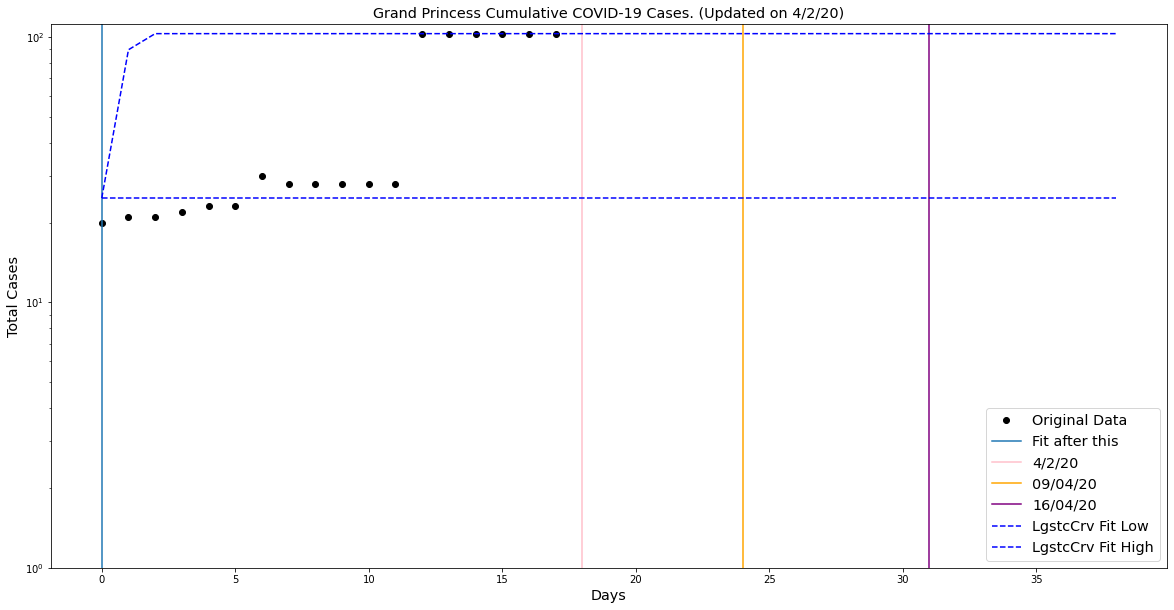

In [9]:
topusstates = usstatesummary[usstatesummary[mostrecentdate] >= 100]
print(topusstates)

print('\n');
inferreddoublingtime = []
recentdoublingtime = []
errors = []
states = []

for state in topusstates.index.values:
    
    if state == "Recovered":
        continue
    
    print('US state: ', state)
    a = plotCases(uscases,'Province/State', state)
    if a:
        states.append(state)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for US COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


                  States  Inferred Doubling Time  95%CI  Recent Doubling Time
0               New York                     5.2    0.4                   5.4
1             New Jersey                     4.4    0.3                   3.7
2               Michigan                     5.7    0.7                   3.6
3             California                     4.4    0.2                   4.8
4              Louisiana                     3.4    0.4                   3.5
5                Florida                     5.6    1.0                   3.6
6          Massachusetts                     3.6    0.4                   3.7
7               Illinois                     4.0    0.4                   4.4
8           Pennsylvania                     3.4    0.2                   3.5
9           

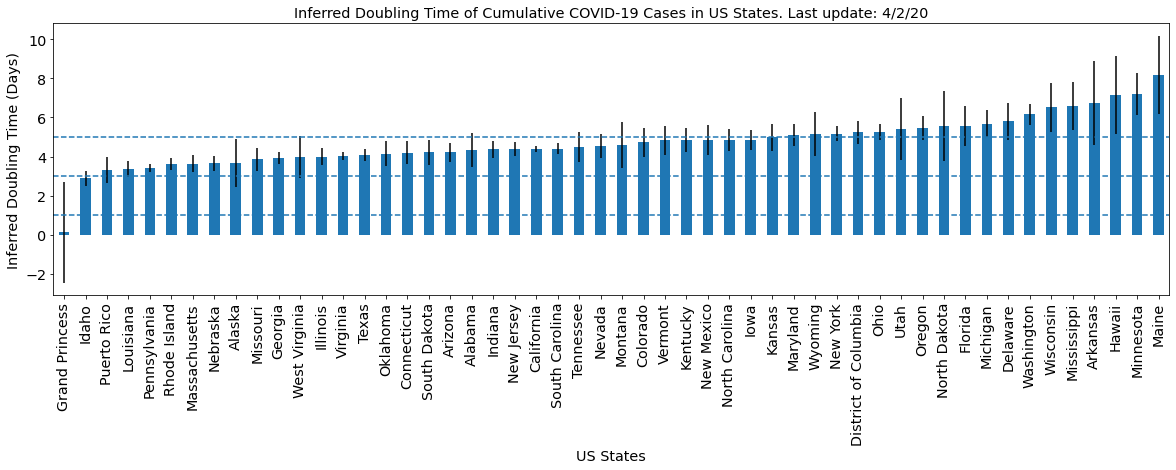

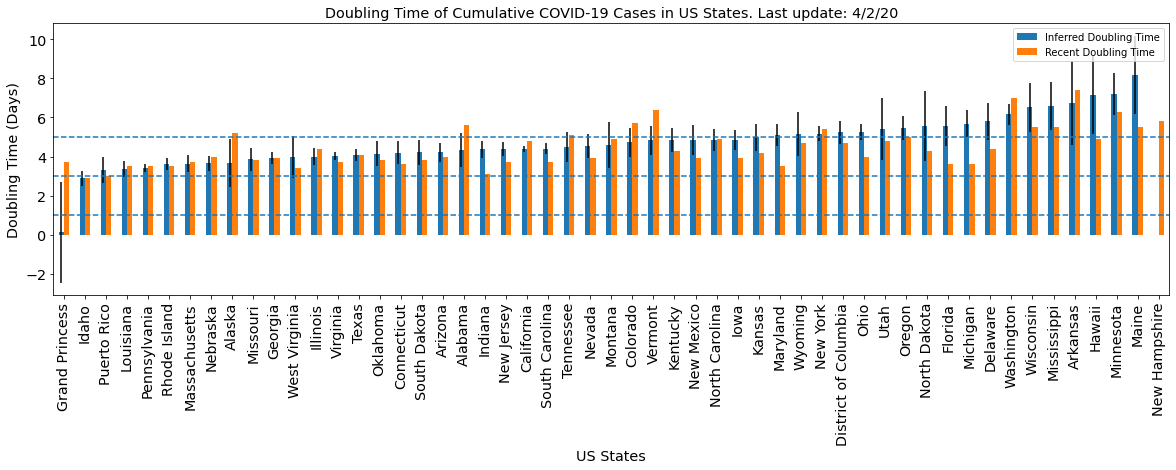

In [10]:
d = {'States': states, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')
print(pd.DataFrame(data=d).round(1))    

print('\n')
dt = pd.DataFrame(data = d).sort_values(by=['Inferred Doubling Time'])
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'States', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(20,5), fontsize="x-large");
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Inferred Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=states
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=states)
dt = dt.sort_values(by=['Inferred Doubling Time'])
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(yerr=err, figsize=(20,5), fontsize="x-large")
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()